In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

#path = "/Volumes/ROHIT/SURE Data/AllDealMinuteData.csv"
path = "/Users/rohitk/Documents/AllDealMinuteDataNew.csv"

In [2]:
from stargazer.stargazer import Stargazer
from IPython.core.display import Latex
from IPython.core.display import HTML

In [3]:
df = pd.read_csv(path)

In [4]:
#df.rename(columns={'ACQ or TAR': 'AorT'},inplace=True)
df.columns

Index(['Minutes', 'DATE', 'Time', 'Datetime', 'PRICE', 'dollar', 'midpoint',
       'wEffectiveSpread_Dollar', 'NBO', 'NBB', 'logPrice', 'returns',
       'Volatility', 'DayVolatility', 'Announced', 'AorT', 'Ticker',
       'QuotedSpread', 'timeNum', 'logVolume', 'TradeVolume',
       'logDayVolatility', 'logOfSpread', 'DayReturns', 'DailyLogOfSpread',
       'DailyLogPrice', 'DailyLogVolume', 'DailySpread', 'DailyPrice',
       'DailyDollarVolume', 'DailyLogDollarVolume', 'DailyDollarVolume.1',
       'DailyShareVolume', 'DailyLogShareVolume'],
      dtype='object')

In [5]:
df = df[df['QuotedSpread'] > 0]

In [6]:
dfDaily = df[['Ticker','QuotedSpread','PRICE','DayVolatility','DATE','midpoint']].groupby(['Ticker','DATE']).median()
dfDaily['totalVolume'] = df[['Ticker','TradeVolume','DATE']].groupby(['Ticker','DATE']).sum()
dfDaily['dollarVolume'] = df[['Ticker','dollar','DATE']].groupby(['Ticker','DATE']).sum()
dfDaily['Announced'] = df[['Ticker','DATE','Announced']].groupby(['Ticker','DATE']).mean()
dfDaily['AorT'] = df[['Ticker','DATE','AorT']].groupby(['Ticker','DATE']).mean()

In [7]:
dfDaily.columns

Index(['QuotedSpread', 'PRICE', 'DayVolatility', 'midpoint', 'totalVolume',
       'dollarVolume', 'Announced', 'AorT'],
      dtype='object')

In [8]:
dfDaily['logPrice'] = np.log(dfDaily['PRICE'])
dfDaily['logDayVolatility'] = np.log(dfDaily['DayVolatility'])
dfDaily['logShareVolume'] = np.log(dfDaily['totalVolume'])
dfDaily['logDollarVolume'] = np.log(dfDaily['dollarVolume'])
dfDaily['logOfSpread'] = np.log(dfDaily['QuotedSpread'])
dfDaily['pctSpread'] = np.log(dfDaily['QuotedSpread'] / dfDaily['midpoint'])

In [9]:
dfDailyGroup = dfDaily.copy(deep=True)
dfDaily = dfDaily.reset_index()

In [10]:
dfDaily.describe()

QuotedSpread        PRICE  DayVolatility     midpoint   totalVolume  \
count   1892.000000  1892.000000    1892.000000  1892.000000  1.892000e+03   
mean       0.036508   111.788746       0.017103   111.788426  5.793821e+06   
std        0.063511   173.517619       0.022593   173.516443  9.376498e+06   
min        0.008506     4.854327       0.001427     4.855000  1.780052e+05   
25%        0.010000    39.865253       0.009390    39.863823  1.656085e+06   
50%        0.013146    60.991157       0.013155    60.990736  2.820075e+06   
75%        0.027080   122.769561       0.019715   122.770895  6.070796e+06   
max        0.556036  1060.478906       0.462394  1060.512940  1.496168e+08   

       dollarVolume    Announced         AorT     logPrice  logDayVolatility  \
count   1892.000000  1892.000000  1892.000000  1892.000000       1892.000000   
mean    4848.095690     0.495772     0.500529     4.213111         -4.319298   
std      647.961942     0.500114     0.500132     0.937068          0.653569   
min     2144.064732     0.000000     0.000000     1.579870         -6.552346   
25%     4501.517969     0.000000     0.000000     3.685505         -4.668124   
50%     4875.916485     0.000000     1.000000     4.110729         -4.330949   
75%     5267.757640     1.000000     1.000000     4.810309         -3.926353   
max     6590.815410     1.000000     1.000000     6.966476         -0.771338   

       logShareVolume  logDollarVolume  logOfSpread    pctSpread  
count     1892.000000      1892.000000  1892.000000  1892.000000  
mean        14.976968         8.476507    -3.932109    -8.145219  
std          1.031049         0.144427     0.925946     0.659096  
min         12.089568         7.670459    -4.767013    -9.776818  
25%         14.319967         8.412170    -4.605170    -8.629592  
50%         14.852274         8.492063    -4.331645    -8.333391  
75%         15.618997         8.569360    -3.608967    -7.716191  
max         18.823588         8.793432    -0.586922    -6.185179

In [10]:
dfDaily[['logOfSpread', 'logDayVolatility','logShareVolume','logPrice','pctSpread']].corr(method='pearson')

logOfSpread  logDayVolatility  logShareVolume  logPrice  \
logOfSpread          1.000000          0.133146       -0.443170  0.749741   
logDayVolatility     0.133146          1.000000        0.197883 -0.262111   
logShareVolume      -0.443170          0.197883        1.000000 -0.323971   
logPrice             0.749741         -0.262111       -0.323971  1.000000   
pctSpread            0.338934          0.559711       -0.161997 -0.368452   

                  pctSpread  
logOfSpread        0.338934  
logDayVolatility   0.559711  
logShareVolume    -0.161997  
logPrice          -0.368452  
pctSpread          1.000000

In [10]:
#ACQ vs TArgets and remove first 5 and last 5 trading minutes
dfACQ = dfDaily[(dfDaily['AorT'] == 1)]
dfTAR = dfDaily[(dfDaily['AorT'] == 0)] 

#TAR and ACQ before and after announcement
dfTARAfter = dfTAR[dfTAR['Announced'] == 1]
dfTARBefore = dfTAR[dfTAR['Announced'] == 0]
dfACQAfter = dfACQ[dfACQ['Announced'] == 1]
dfACQBefore = dfACQ[dfACQ['Announced'] == 0]

In [20]:
#ACQ regression
regACQ = smf.ols('pctSpread ~ logShareVolume + logPrice + logDayVolatility + Announced',data=dfACQ).fit(cov_type='HAC',cov_kwds={'maxlags':2})
print(regACQ.summary())

                            OLS Regression Results                            
Dep. Variable:              pctSpread   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     52.63
Date:                Fri, 09 Apr 2021   Prob (F-statistic):           4.84e-40
Time:                        20:43:51   Log-Likelihood:                -400.32
No. Observations:                 947   AIC:                             810.6
Df Residuals:                     942   BIC:                             834.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -3.2171      0.397  

In [23]:
#TAR regression
regTAR = smf.ols('pctSpread ~ logShareVolume + logPrice + logDayVolatility + Announced',data=dfTAR).fit(cov_type='HAC',cov_kwds={'maxlags':2})
print(regTAR.summary())

                            OLS Regression Results                            
Dep. Variable:              pctSpread   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     225.4
Date:                Fri, 09 Apr 2021   Prob (F-statistic):          1.21e-135
Time:                        20:45:23   Log-Likelihood:                -589.64
No. Observations:                 945   AIC:                             1189.
Df Residuals:                     940   BIC:                             1214.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.1744      0.496  

In [11]:
dfCashTAR = dfDaily[(dfDaily['Ticker'] == 'WFM') | (dfDaily['Ticker'] == 'RHT') | (dfDaily['Ticker'] == 'LNKD') | (dfDaily['Ticker'] == 'ARRY') | (dfDaily['Ticker'] == 'CA')]
dfHybridTAR = dfDaily[(dfDaily['Ticker'] == 'WP') | (dfDaily['Ticker'] == 'APC') | (dfDaily['Ticker'] == 'COL') | (dfDaily['Ticker'] == 'LLTC')]
dfStockTAR = dfDaily[(dfDaily['Ticker'] == 'LLL') | (dfDaily['Ticker'] == 'ETP') | (dfDaily['Ticker'] == 'S') | (dfDaily['Ticker'] == 'WPZ') | (dfDaily['Ticker'] == 'FDC')| (dfDaily['Ticker'] == 'SCG')]

In [12]:
dfCashACQ = dfDaily[(dfDaily['Ticker'] == 'AMZN') | (dfDaily['Ticker'] == 'IBM') | (dfDaily['Ticker'] == 'MSFT') | (dfDaily['Ticker'] == 'PFE') | (dfDaily['Ticker'] == 'AVGO')]
dfHybridACQ = dfDaily[(dfDaily['Ticker'] == 'FIS') | (dfDaily['Ticker'] == 'OXY') | (dfDaily['Ticker'] == 'UTX') | (dfDaily['Ticker'] == 'ADI')]
dfStockACQ = dfDaily[(dfDaily['Ticker'] == 'HRS') | (dfDaily['Ticker'] == 'SXL') | (dfDaily['Ticker'] == 'TMUS') | (dfDaily['Ticker'] == 'WMB') | (dfDaily['Ticker'] == 'FISV')| (dfDaily['Ticker'] == 'D')]

In [26]:
#TAR cash deals
regTARcash = smf.ols('pctSpread ~ logShareVolume + logPrice + logDayVolatility + Announced',data=dfCashTAR).fit(cov_type='HAC',cov_kwds={'maxlags':2})
print(regTARcash.summary())

                            OLS Regression Results                            
Dep. Variable:              pctSpread   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     51.15
Date:                Fri, 09 Apr 2021   Prob (F-statistic):           4.31e-33
Time:                        20:45:42   Log-Likelihood:                -148.38
No. Observations:                 317   AIC:                             306.8
Df Residuals:                     312   BIC:                             325.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -3.7914      1.022  

In [27]:
# TAR Hybrid Deals
regTARhy = smf.ols('pctSpread ~ logShareVolume + logPrice + logDayVolatility + Announced',data=dfHybridTAR).fit(cov_type='HAC',cov_kwds={'maxlags':2})
print(regTARhy.summary())

                            OLS Regression Results                            
Dep. Variable:              pctSpread   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     54.18
Date:                Fri, 09 Apr 2021   Prob (F-statistic):           7.62e-33
Time:                        20:45:51   Log-Likelihood:                 45.267
No. Observations:                 255   AIC:                            -80.53
Df Residuals:                     250   BIC:                            -62.83
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -5.7899      0.498  

In [28]:
# Stock TAR deals
regTARstock = smf.ols('pctSpread ~ logShareVolume + logPrice + logDayVolatility + Announced',data=dfStockTAR).fit(cov_type='HAC',cov_kwds={'maxlags':2})
print(regTARstock.summary())

                            OLS Regression Results                            
Dep. Variable:              pctSpread   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     47.43
Date:                Fri, 09 Apr 2021   Prob (F-statistic):           3.81e-32
Time:                        20:45:56   Log-Likelihood:                -218.73
No. Observations:                 373   AIC:                             447.5
Df Residuals:                     368   BIC:                             467.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.0656      0.731  

In [29]:
#Cash deals ACQ
regACQcash = smf.ols('pctSpread ~ logShareVolume + logPrice + logDayVolatility + Announced',data=dfCashACQ).fit(cov_type='HAC',cov_kwds={'maxlags':2})
print(regACQcash.summary())

                            OLS Regression Results                            
Dep. Variable:              pctSpread   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     33.19
Date:                Fri, 09 Apr 2021   Prob (F-statistic):           4.30e-23
Time:                        20:46:03   Log-Likelihood:                -60.120
No. Observations:                 319   AIC:                             130.2
Df Residuals:                     314   BIC:                             149.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -7.7118      0.951  

In [30]:
#Hydbrid deals ACQ
regACQhy = smf.ols('pctSpread ~ logShareVolume + logPrice + logDayVolatility + Announced',data=dfHybridACQ).fit(cov_type='HAC',cov_kwds={'maxlags':2})
print(regACQhy.summary())

                            OLS Regression Results                            
Dep. Variable:              pctSpread   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     13.13
Date:                Fri, 09 Apr 2021   Prob (F-statistic):           1.01e-09
Time:                        20:46:08   Log-Likelihood:                 93.545
No. Observations:                 255   AIC:                            -177.1
Df Residuals:                     250   BIC:                            -159.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -6.2389      0.469  

In [31]:
#Stock deals ACQ
regACQstock = smf.ols('pctSpread ~ logShareVolume + logPrice + logDayVolatility + Announced',data=dfStockACQ).fit(cov_type='HAC',cov_kwds={'maxlags':2})
print(regACQstock.summary())

                            OLS Regression Results                            
Dep. Variable:              pctSpread   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     88.25
Date:                Fri, 09 Apr 2021   Prob (F-statistic):           1.65e-52
Time:                        20:46:16   Log-Likelihood:                -102.12
No. Observations:                 373   AIC:                             214.2
Df Residuals:                     368   BIC:                             233.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.9316      0.572  

In [54]:
stargazer = Stargazer([regTAR, regTARcash,regTARhy,regTARstock])
stargazer.title('Target Spreads Robust Regression')
stargazer.custom_columns(['All Targets','Cash Deals','Cash/Stock Deals','Stock Deals'],[1,1,1,1])
Latex(stargazer.render_latex())

<IPython.core.display.Latex object>

In [55]:
stargazer = Stargazer([regACQ, regACQcash,regACQhy,regACQstock])
stargazer.title('Acquirer Spreads Robust Regression')
stargazer.custom_columns(['All Acquirers','Cash Deals','Cash/Stock Deals','Stock Deals'],[1,1,1,1])
Latex(stargazer.render_latex())

<IPython.core.display.Latex object>

In [13]:
dfTARGroup = dfDailyGroup[dfDailyGroup['AorT'] == 0]
dfACQGroup = dfDailyGroup[dfDailyGroup['AorT'] == 1]
dfTARGroup.index.levels[-1].astype('str')
dfACQGroup.index.levels[-1].astype('str')

Index(['2016-05-02', '2016-05-03', '2016-05-04', '2016-05-05', '2016-05-06',
       '2016-05-09', '2016-05-10', '2016-05-11', '2016-05-12', '2016-05-13',
       ...
       '2019-07-18', '2019-07-19', '2019-07-22', '2019-07-23', '2019-07-24',
       '2019-07-25', '2019-07-26', '2019-07-29', '2019-07-30', '2019-07-31'],
      dtype='object', name='DATE', length=695)

In [14]:
AMZN_DT_Arr = dfACQGroup.xs('AMZN').index.to_numpy()
WFM_DT_Arr = dfTARGroup.xs('WFM').index.to_numpy()
AMZN_DT = np.where(AMZN_DT_Arr == '2017-06-16')[0][0]
WFM_DT = np.where(WFM_DT_Arr == '2017-06-16')[0][0]

FIS_DT_Arr = dfACQGroup.xs('FIS').index.to_numpy()
WP_DT_Arr = dfTARGroup.xs('WP').index.to_numpy()
FIS_DT = np.where(FIS_DT_Arr == '2019-03-18')[0][0]
WP_DT = np.where(WP_DT_Arr == '2019-03-18')[0][0]

HRS_DT_Arr = dfACQGroup.xs('HRS').index.to_numpy()
LLL_DT_Arr = dfTARGroup.xs('LLL').index.to_numpy()
HRS_DT = np.where(HRS_DT_Arr == '2018-10-15')[0][0]
LLL_DT = np.where(LLL_DT_Arr == '2018-10-15')[0][0]

IBM_DT_Arr = dfACQGroup.xs('IBM').index.to_numpy()
RHT_DT_Arr = dfTARGroup.xs('RHT').index.to_numpy()
IBM_DT = np.where(IBM_DT_Arr == '2018-10-29')[0][0]
RHT_DT = np.where(RHT_DT_Arr == '2018-10-29')[0][0]

MSFT_DT_Arr = dfACQGroup.xs('MSFT').index.to_numpy()
LNKD_DT_Arr = dfTARGroup.xs('LNKD').index.to_numpy()
MSFT_DT = np.where(MSFT_DT_Arr == '2016-06-13')[0][0]
LNKD_DT = np.where(LNKD_DT_Arr == '2016-06-13')[0][0]

OXY_DT_Arr = dfACQGroup.xs('OXY').index.to_numpy()
APC_DT_Arr = dfTARGroup.xs('APC').index.to_numpy()
OXY_DT = np.where(OXY_DT_Arr == '2019-04-24')[0][0]
APC_DT = np.where(APC_DT_Arr == '2019-04-24')[0][0]

PFE_DT_Arr = dfACQGroup.xs('PFE').index.to_numpy()
ARRY_DT_Arr = dfTARGroup.xs('ARRY').index.to_numpy()
PFE_DT = np.where(PFE_DT_Arr == '2019-06-17')[0][0]
ARRY_DT = np.where(ARRY_DT_Arr == '2019-06-17')[0][0]

SXL_DT_Arr = dfACQGroup.xs('SXL').index.to_numpy()
ETP_DT_Arr = dfTARGroup.xs('ETP').index.to_numpy()
SXL_DT = np.where(SXL_DT_Arr == '2016-11-21')[0][0]
ETP_DT = np.where(ETP_DT_Arr == '2016-11-21')[0][0]

TMUS_DT_Arr = dfACQGroup.xs('TMUS').index.to_numpy()
S_DT_Arr = dfTARGroup.xs('S').index.to_numpy()
TMUS_DT = np.where(TMUS_DT_Arr == '2018-04-30')[0][0]
S_DT = np.where(S_DT_Arr == '2018-04-30')[0][0]

UTX_DT_Arr = dfACQGroup.xs('UTX').index.to_numpy()
COL_DT_Arr = dfTARGroup.xs('COL').index.to_numpy()
UTX_DT = np.where(UTX_DT_Arr == '2017-09-05')[0][0] #correct for labour day
COL_DT = np.where(COL_DT_Arr == '2017-09-05')[0][0] #correct for labour day

ADI_DT_Arr = dfACQGroup.xs('ADI').index.to_numpy()
LLTC_DT_Arr = dfTARGroup.xs('LLTC').index.to_numpy()
ADI_DT = np.where(ADI_DT_Arr == '2016-07-26')[0][0]
LLTC_DT = np.where(LLTC_DT_Arr == '2016-07-26')[0][0]

D_DT_Arr = dfACQGroup.xs('D').index.to_numpy()
SCG_DT_Arr = dfTARGroup.xs('SCG').index.to_numpy()
D_DT = np.where(D_DT_Arr == '2018-01-03')[0][0]
SCG_DT = np.where(SCG_DT_Arr == '2018-01-03')[0][0]

WMB_DT_Arr = dfACQGroup.xs('WMB').index.to_numpy()
WPZ_DT_Arr = dfTARGroup.xs('WPZ').index.to_numpy()
WMB_DT = np.where(WMB_DT_Arr == '2018-05-17')[0][0]
WPZ_DT = np.where(WPZ_DT_Arr == '2018-05-17')[0][0]

AVGO_DT_Arr = dfACQGroup.xs('AVGO').index.to_numpy()
CA_DT_Arr = dfTARGroup.xs('CA').index.to_numpy()
AVGO_DT = np.where(AVGO_DT_Arr == '2018-07-12')[0][0] #overnight adjustment
CA_DT = np.where(CA_DT_Arr == '2018-07-12')[0][0] #overnight adjustment

FISV_DT_Arr = dfACQGroup.xs('FISV').index.to_numpy()
FDC_DT_Arr = dfTARGroup.xs('FDC').index.to_numpy()
FISV_DT = np.where(FISV_DT_Arr == '2019-01-16')[0][0]
FDC_DT = np.where(FDC_DT_Arr == '2019-01-16')[0][0]

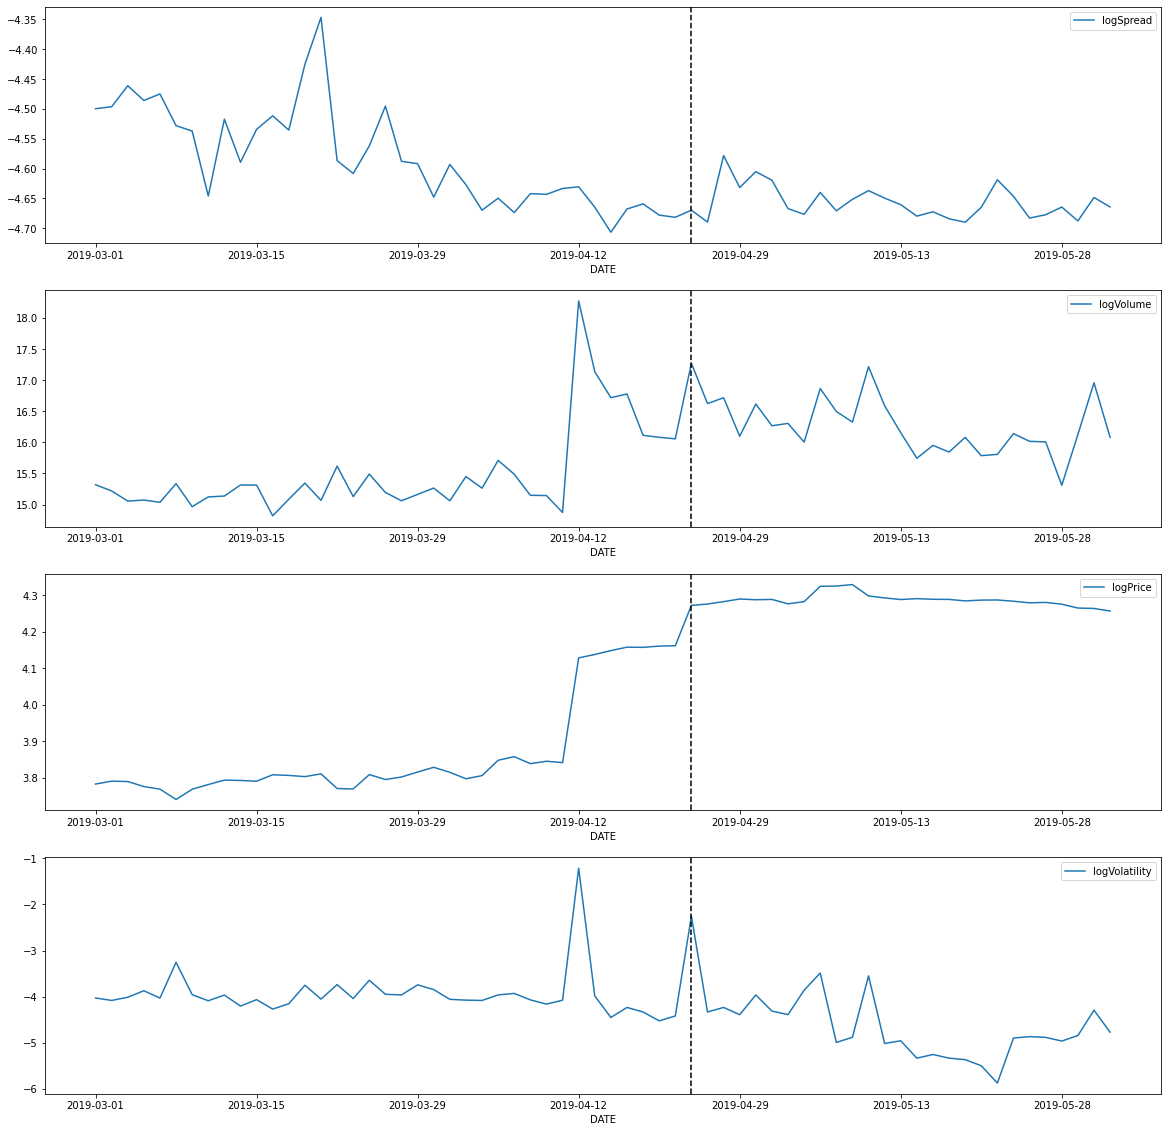

In [86]:
# Hybrid + Rumor 
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroup.xs('APC').plot(y='logOfSpread',ax=a[0],label='logSpread')
a[0].axvline(APC_DT, color='k', linestyle='--')
dfTARGroup.xs('APC').plot(y='logShareVolume',ax=a[1],label='logVolume')
a[1].axvline(APC_DT, color='k', linestyle='--')
dfTARGroup.xs('APC').plot(y='logPrice',ax=a[2],label='logPrice')
a[2].axvline(APC_DT, color='k', linestyle='--')
dfTARGroup.xs('APC').plot(y='logDayVolatility',ax=a[3],label='logVolatility')
a[3].axvline(APC_DT, color='k', linestyle='--')

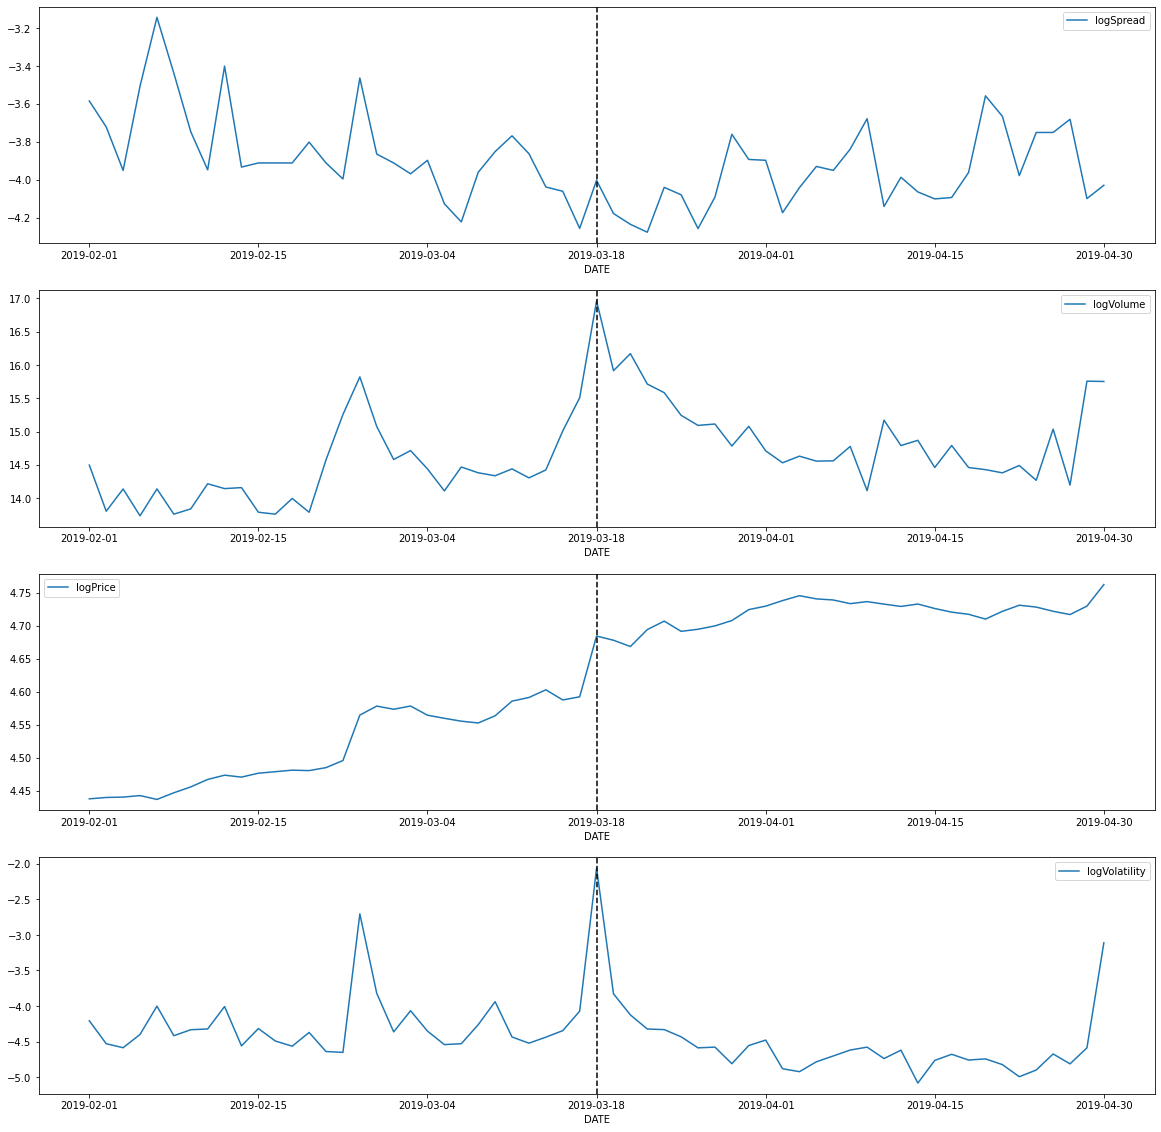

In [87]:
#Hybrid deal
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroup.xs('WP').plot(y='logOfSpread',ax=a[0],label='logSpread')
a[0].axvline(WP_DT, color='k', linestyle='--')
dfTARGroup.xs('WP').plot(y='logShareVolume',ax=a[1],label='logVolume')
a[1].axvline(WP_DT, color='k', linestyle='--')
dfTARGroup.xs('WP').plot(y='logPrice',ax=a[2],label='logPrice')
a[2].axvline(WP_DT, color='k', linestyle='--')
dfTARGroup.xs('WP').plot(y='logDayVolatility',ax=a[3],label='logVolatility')
a[3].axvline(WP_DT, color='k', linestyle='--')

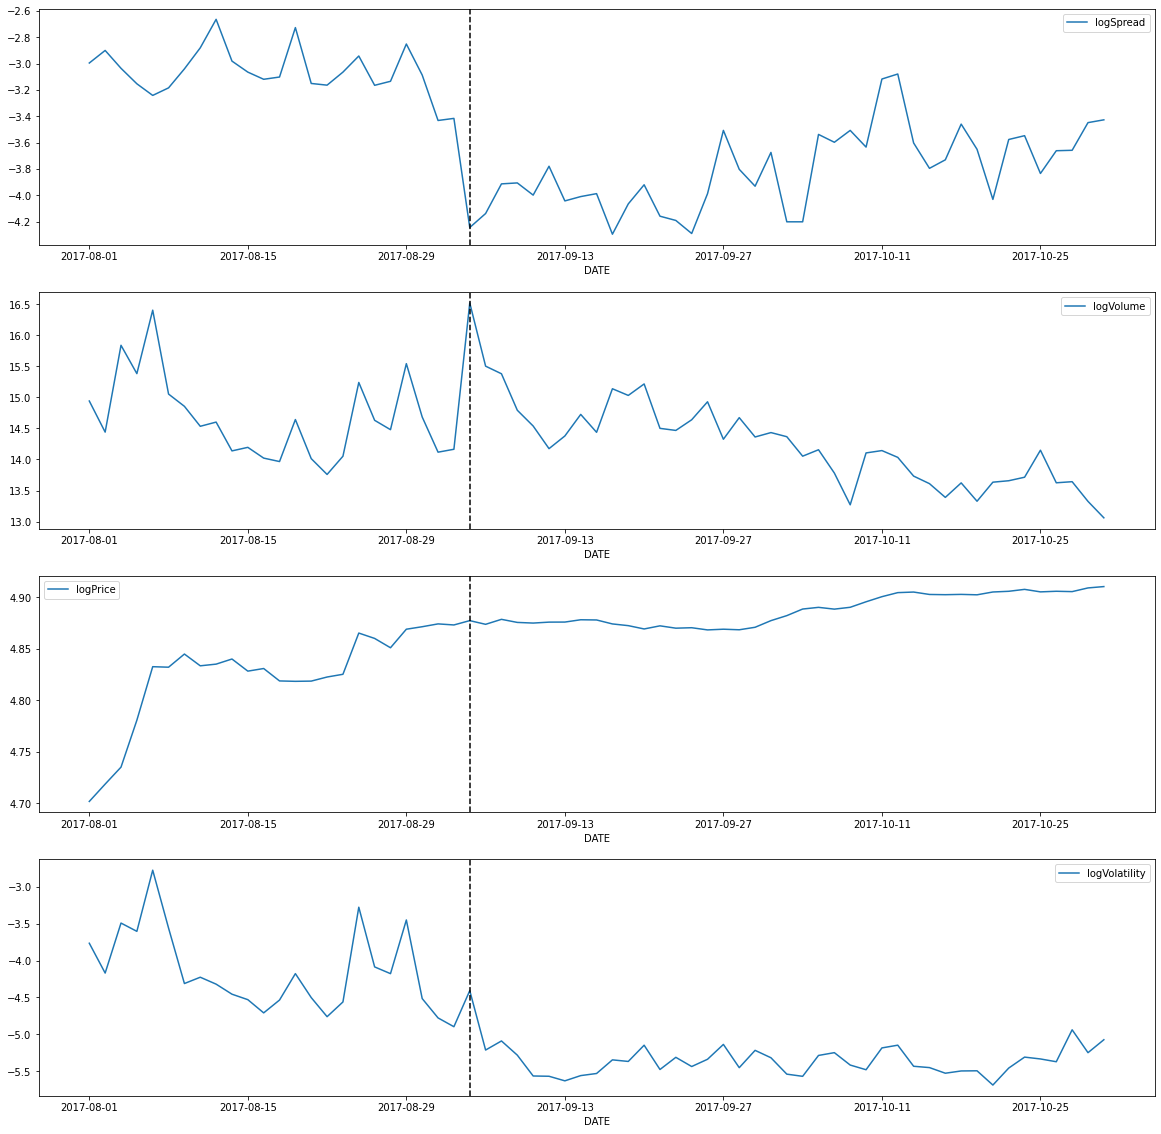

In [88]:
#Hybrid + Rumor
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroup.xs('COL').plot(y='logOfSpread',ax=a[0],label='logSpread')
a[0].axvline(COL_DT, color='k', linestyle='--')
dfTARGroup.xs('COL').plot(y='logShareVolume',ax=a[1],label='logVolume')
a[1].axvline(COL_DT, color='k', linestyle='--')
dfTARGroup.xs('COL').plot(y='logPrice',ax=a[2],label='logPrice')
a[2].axvline(COL_DT, color='k', linestyle='--')
dfTARGroup.xs('COL').plot(y='logDayVolatility',ax=a[3],label='logVolatility')
a[3].axvline(COL_DT, color='k', linestyle='--')

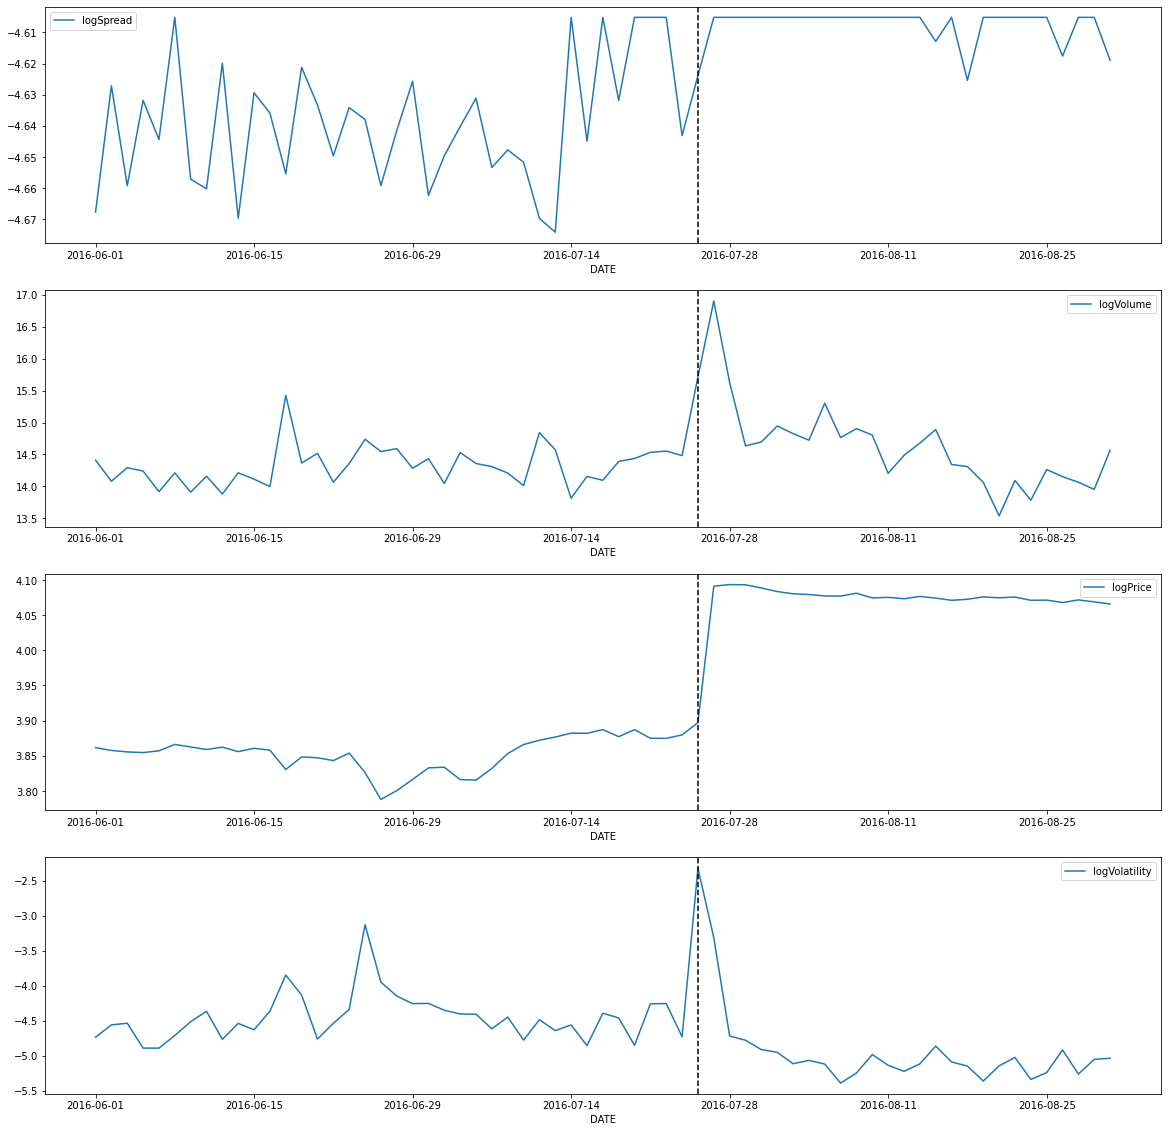

In [89]:
#Hybrid
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroup.xs('LLTC').plot(y='logOfSpread',ax=a[0],label='logSpread')
a[0].axvline(LLTC_DT, color='k', linestyle='--')
dfTARGroup.xs('LLTC').plot(y='logShareVolume',ax=a[1],label='logVolume')
a[1].axvline(LLTC_DT, color='k', linestyle='--')
dfTARGroup.xs('LLTC').plot(y='logPrice',ax=a[2],label='logPrice')
a[2].axvline(LLTC_DT, color='k', linestyle='--')
dfTARGroup.xs('LLTC').plot(y='logDayVolatility',ax=a[3],label='logVolatility')
a[3].axvline(LLTC_DT, color='k', linestyle='--')

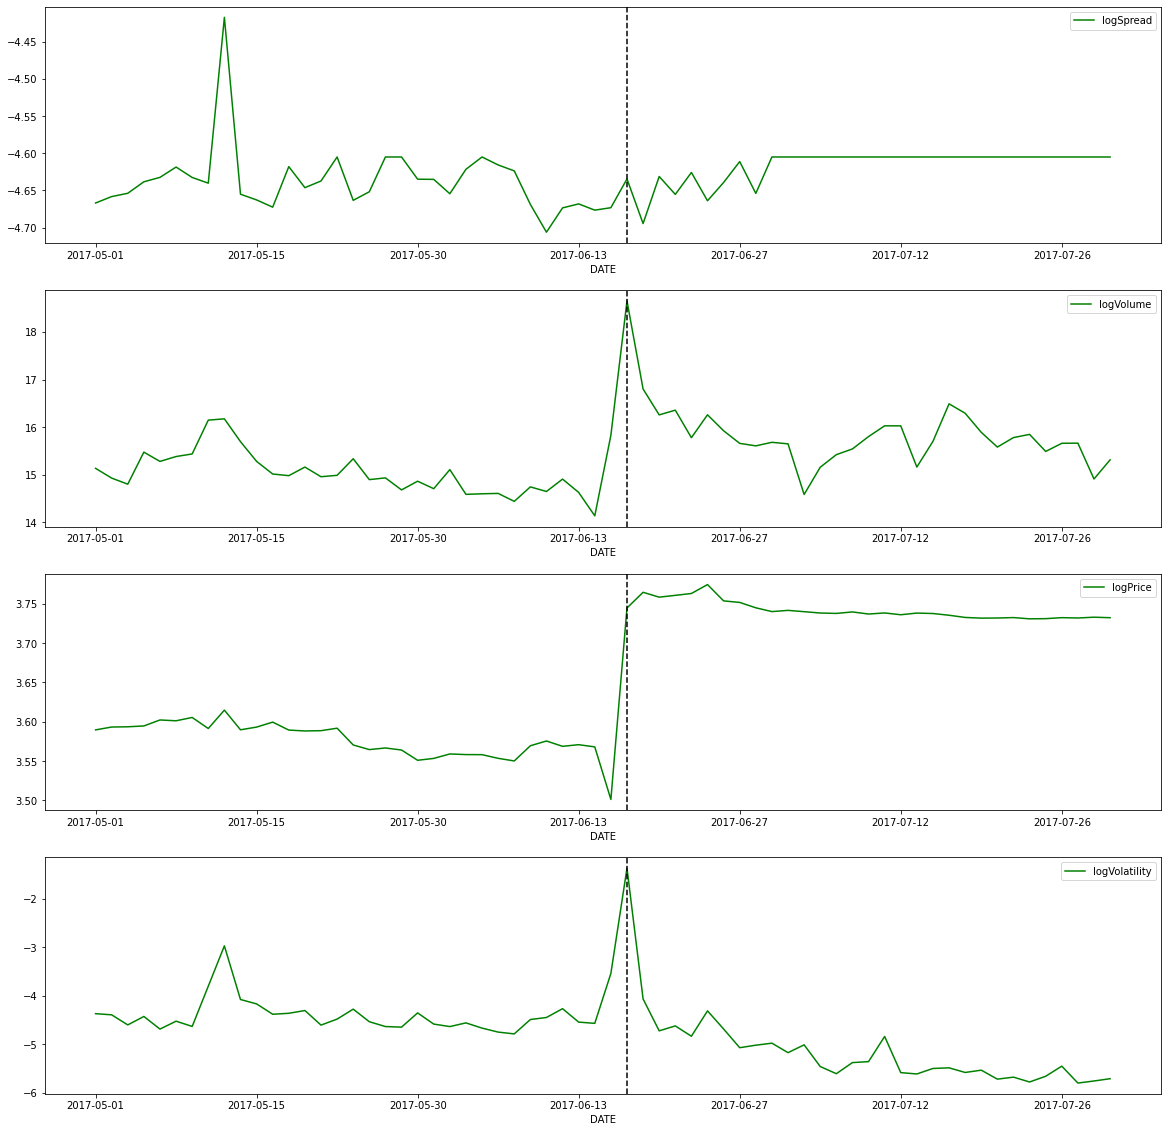

In [90]:
#Cash
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroup.xs('WFM').plot(y='logOfSpread',ax=a[0],label='logSpread',color='g')
a[0].axvline(WFM_DT, color='k', linestyle='--')
dfTARGroup.xs('WFM').plot(y='logShareVolume',ax=a[1],label='logVolume',color='g')
a[1].axvline(WFM_DT, color='k', linestyle='--')
dfTARGroup.xs('WFM').plot(y='logPrice',ax=a[2],label='logPrice',color='g')
a[2].axvline(WFM_DT, color='k', linestyle='--')
dfTARGroup.xs('WFM').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='g')
a[3].axvline(WFM_DT, color='k', linestyle='--')

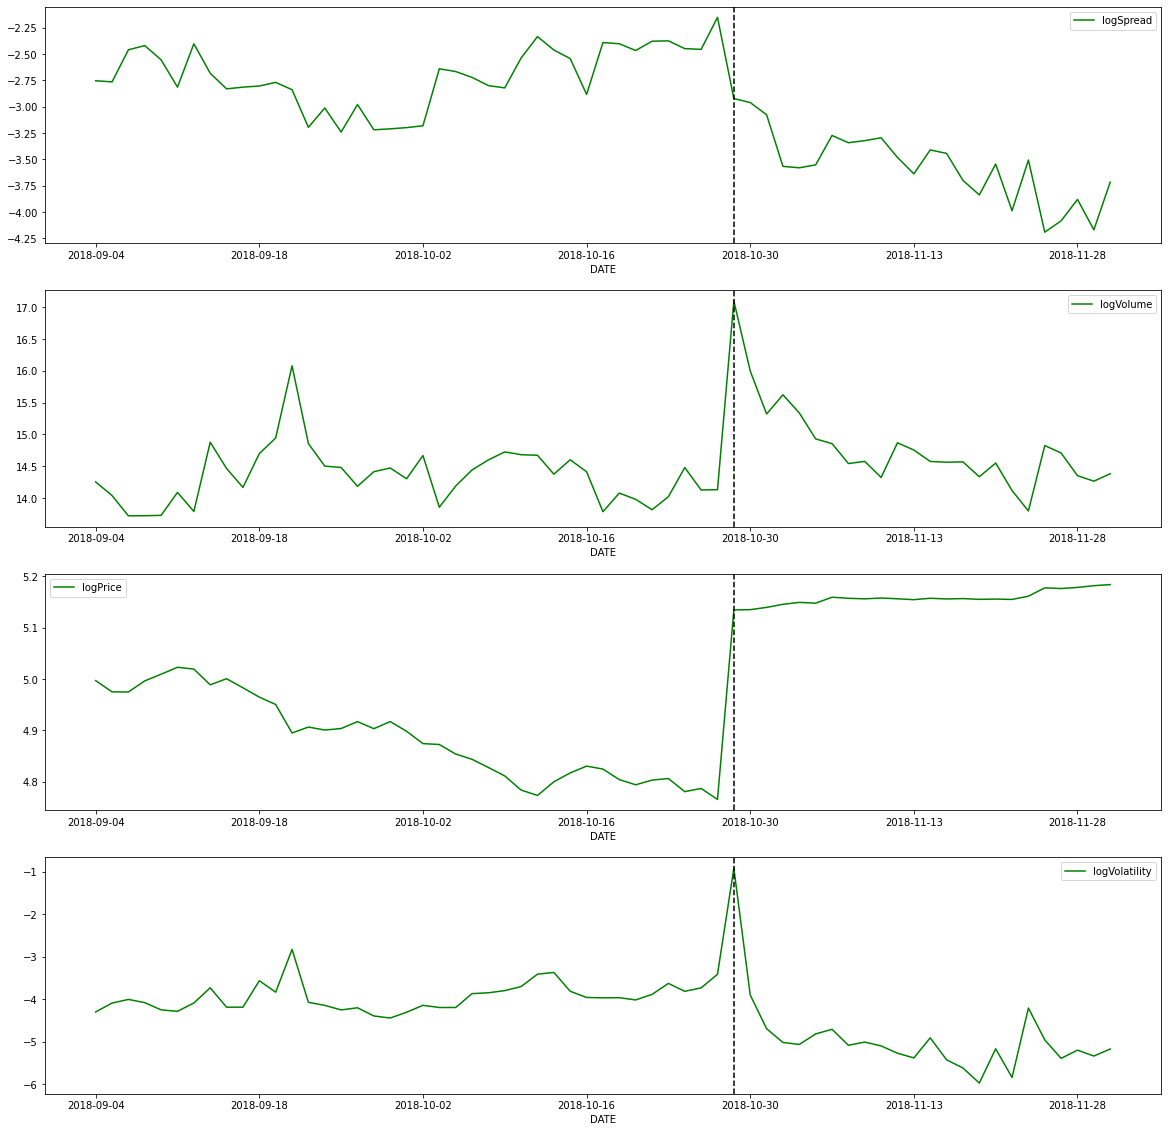

In [91]:
#Cash
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroup.xs('RHT').plot(y='logOfSpread',ax=a[0],label='logSpread',color='g')
a[0].axvline(RHT_DT, color='k', linestyle='--')
dfTARGroup.xs('RHT').plot(y='logShareVolume',ax=a[1],label='logVolume',color='g')
a[1].axvline(RHT_DT, color='k', linestyle='--')
dfTARGroup.xs('RHT').plot(y='logPrice',ax=a[2],label='logPrice',color='g')
a[2].axvline(RHT_DT, color='k', linestyle='--')
dfTARGroup.xs('RHT').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='g')
a[3].axvline(RHT_DT, color='k', linestyle='--')

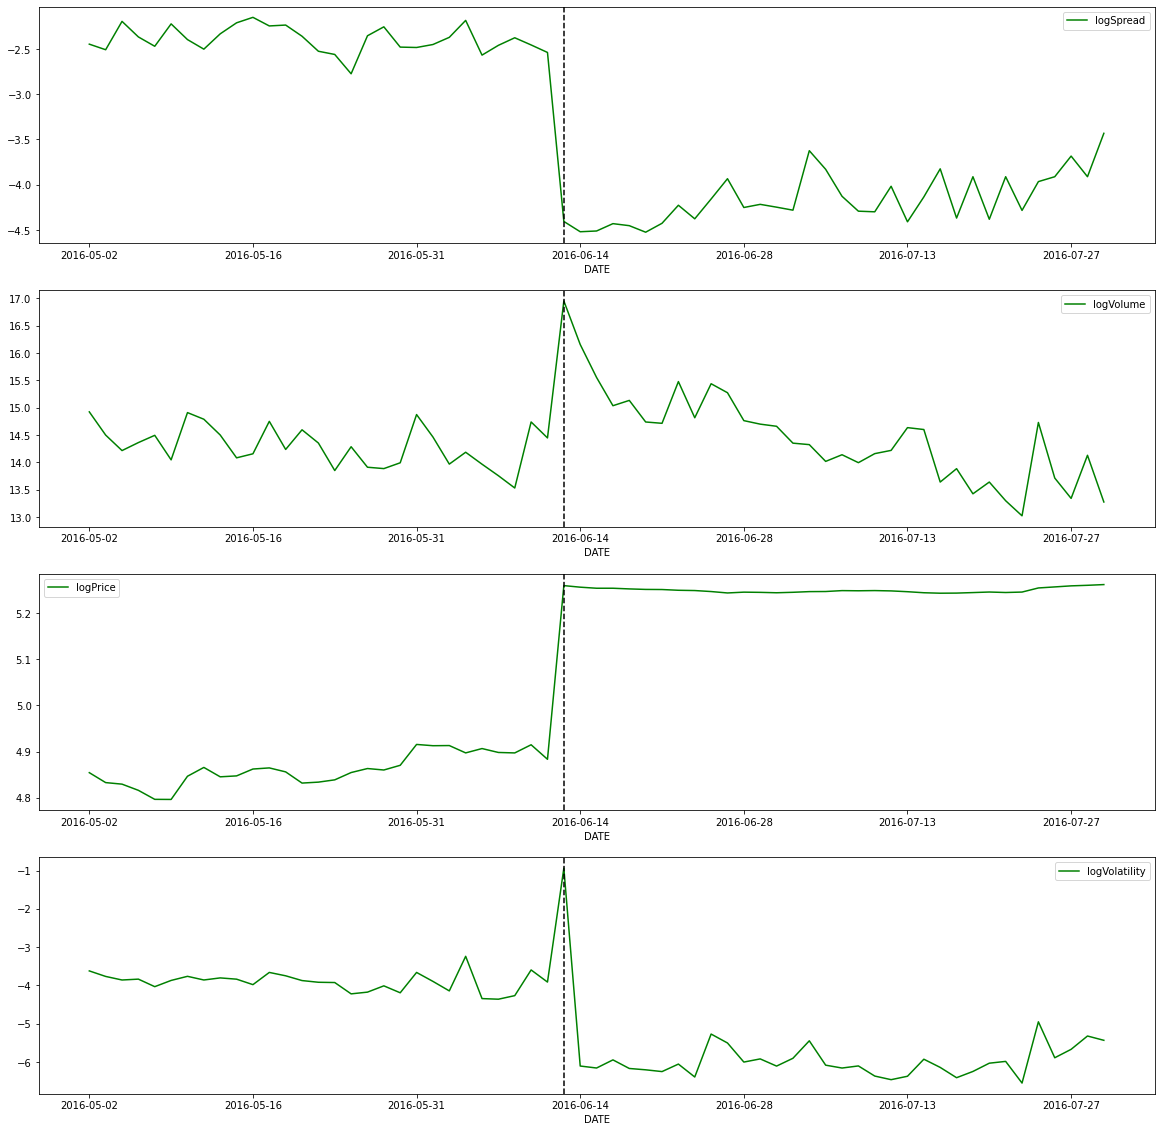

In [92]:
#Cash
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroup.xs('LNKD').plot(y='logOfSpread',ax=a[0],label='logSpread',color='g')
a[0].axvline(LNKD_DT, color='k', linestyle='--')
dfTARGroup.xs('LNKD').plot(y='logShareVolume',ax=a[1],label='logVolume',color='g')
a[1].axvline(LNKD_DT, color='k', linestyle='--')
dfTARGroup.xs('LNKD').plot(y='logPrice',ax=a[2],label='logPrice',color='g')
a[2].axvline(LNKD_DT, color='k', linestyle='--')
dfTARGroup.xs('LNKD').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='g')
a[3].axvline(LNKD_DT, color='k', linestyle='--')

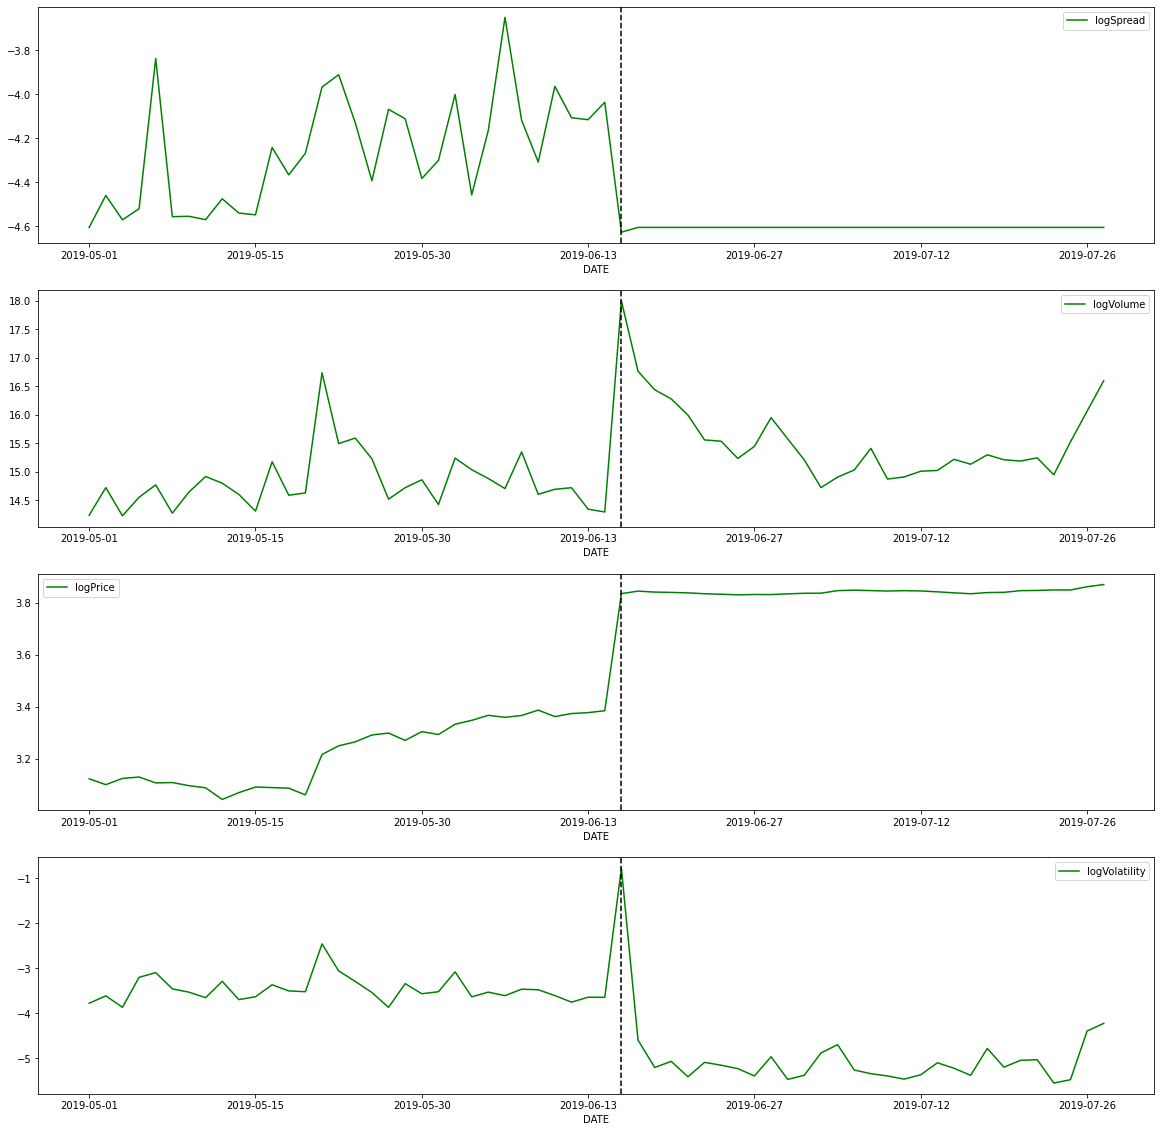

In [93]:
#Cash
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroup.xs('ARRY').plot(y='logOfSpread',ax=a[0],label='logSpread',color='g')
a[0].axvline(ARRY_DT, color='k', linestyle='--')
dfTARGroup.xs('ARRY').plot(y='logShareVolume',ax=a[1],label='logVolume',color='g')
a[1].axvline(ARRY_DT, color='k', linestyle='--')
dfTARGroup.xs('ARRY').plot(y='logPrice',ax=a[2],label='logPrice',color='g')
a[2].axvline(ARRY_DT, color='k', linestyle='--')
dfTARGroup.xs('ARRY').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='g')
a[3].axvline(ARRY_DT, color='k', linestyle='--')

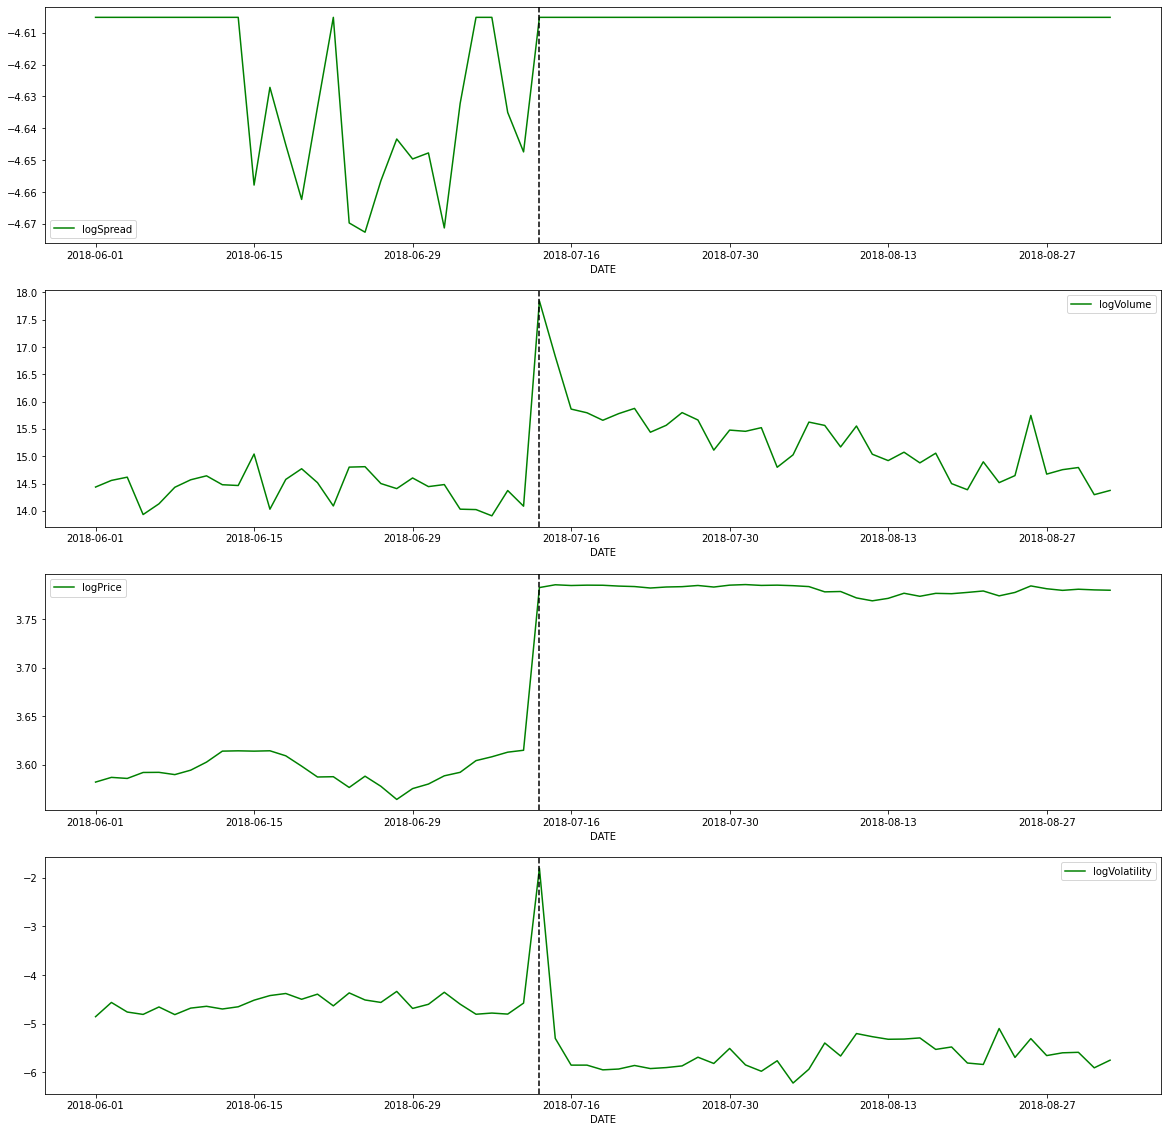

In [94]:
#Cash + Rumor
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroup.xs('CA').plot(y='logOfSpread',ax=a[0],label='logSpread',color='g')
a[0].axvline(CA_DT, color='k', linestyle='--')
dfTARGroup.xs('CA').plot(y='logShareVolume',ax=a[1],label='logVolume',color='g')
a[1].axvline(CA_DT, color='k', linestyle='--')
dfTARGroup.xs('CA').plot(y='logPrice',ax=a[2],label='logPrice',color='g')
a[2].axvline(CA_DT, color='k', linestyle='--')
dfTARGroup.xs('CA').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='g')
a[3].axvline(CA_DT, color='k', linestyle='--')

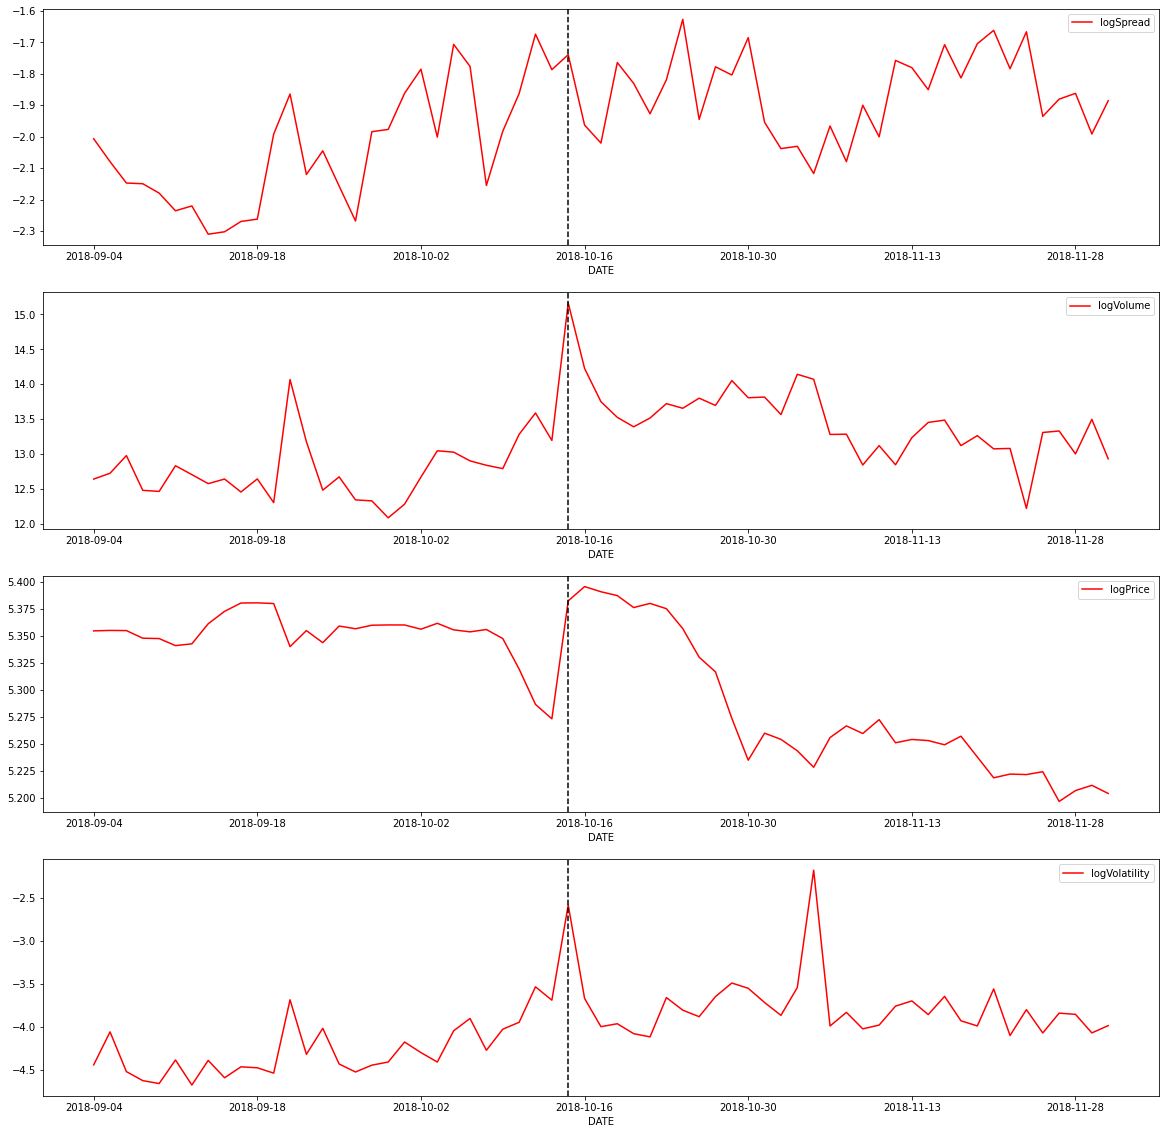

In [95]:
#Stock 
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroup.xs('LLL').plot(y='logOfSpread',ax=a[0],label='logSpread',color='r')
a[0].axvline(LLL_DT, color='k', linestyle='--')
dfTARGroup.xs('LLL').plot(y='logShareVolume',ax=a[1],label='logVolume',color='r')
a[1].axvline(LLL_DT, color='k', linestyle='--')
dfTARGroup.xs('LLL').plot(y='logPrice',ax=a[2],label='logPrice',color='r')
a[2].axvline(LLL_DT, color='k', linestyle='--')
dfTARGroup.xs('LLL').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='r')
a[3].axvline(LLL_DT, color='k', linestyle='--')

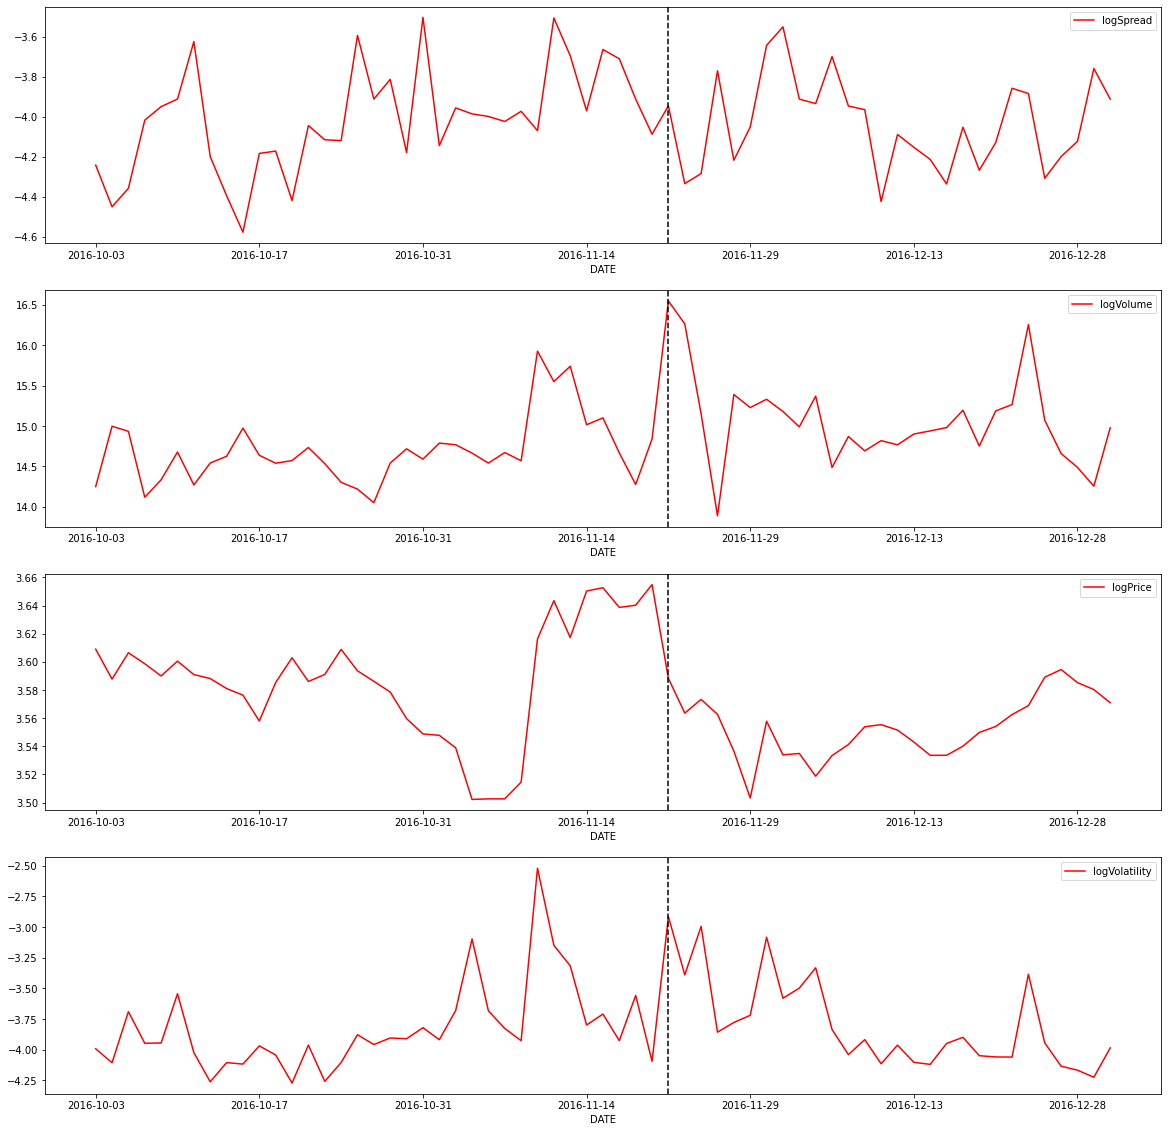

In [96]:
#Stock 
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroup.xs('ETP').plot(y='logOfSpread',ax=a[0],label='logSpread',color='r')
a[0].axvline(ETP_DT, color='k', linestyle='--')
dfTARGroup.xs('ETP').plot(y='logShareVolume',ax=a[1],label='logVolume',color='r')
a[1].axvline(ETP_DT, color='k', linestyle='--')
dfTARGroup.xs('ETP').plot(y='logPrice',ax=a[2],label='logPrice',color='r')
a[2].axvline(ETP_DT, color='k', linestyle='--')
dfTARGroup.xs('ETP').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='r')
a[3].axvline(ETP_DT, color='k', linestyle='--')

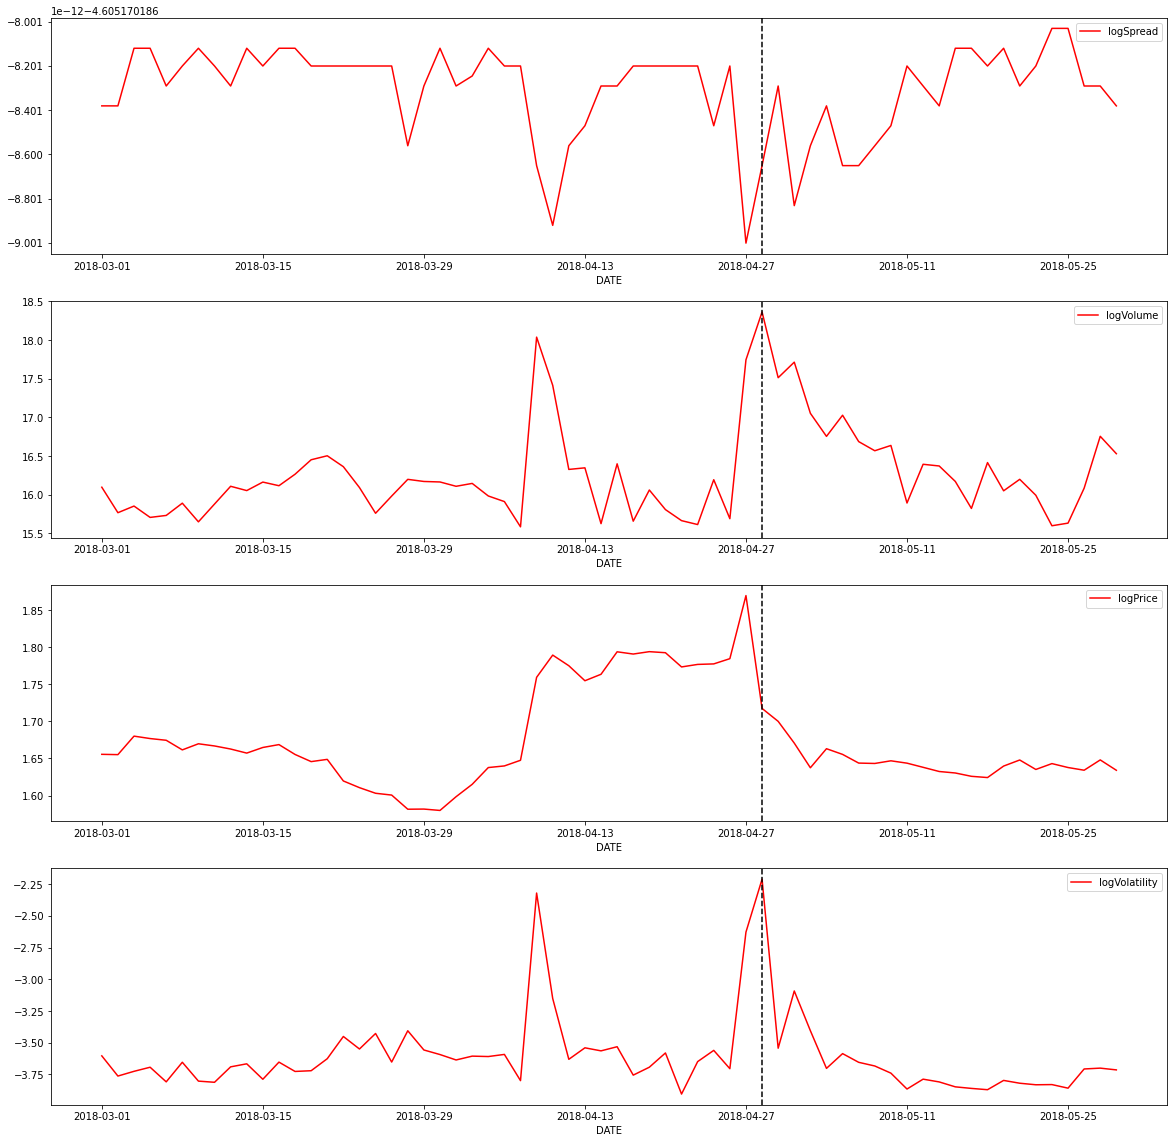

In [97]:
#Stock + Rumor
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroup.xs('S').plot(y='logOfSpread',ax=a[0],label='logSpread',color='r')
a[0].axvline(S_DT, color='k', linestyle='--')
dfTARGroup.xs('S').plot(y='logShareVolume',ax=a[1],label='logVolume',color='r')
a[1].axvline(S_DT, color='k', linestyle='--')
dfTARGroup.xs('S').plot(y='logPrice',ax=a[2],label='logPrice',color='r')
a[2].axvline(S_DT, color='k', linestyle='--')
dfTARGroup.xs('S').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='r')
a[3].axvline(S_DT, color='k', linestyle='--')

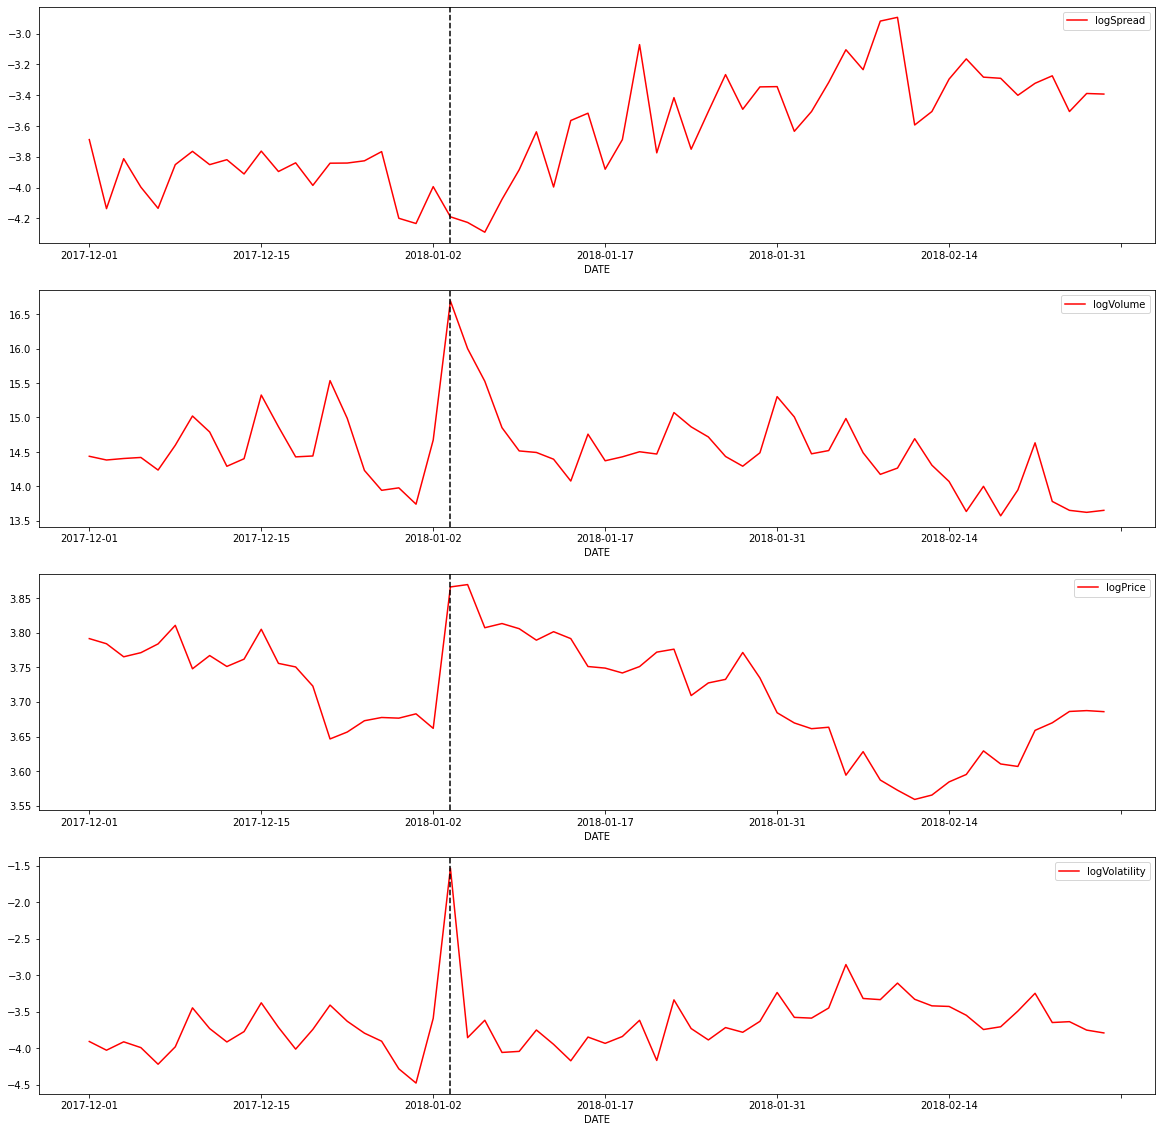

In [98]:
#Stock
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroup.xs('SCG').plot(y='logOfSpread',ax=a[0],label='logSpread',color='r')
a[0].axvline(SCG_DT, color='k', linestyle='--')
dfTARGroup.xs('SCG').plot(y='logShareVolume',ax=a[1],label='logVolume',color='r')
a[1].axvline(SCG_DT, color='k', linestyle='--')
dfTARGroup.xs('SCG').plot(y='logPrice',ax=a[2],label='logPrice',color='r')
a[2].axvline(SCG_DT, color='k', linestyle='--')
dfTARGroup.xs('SCG').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='r')
a[3].axvline(SCG_DT, color='k', linestyle='--')

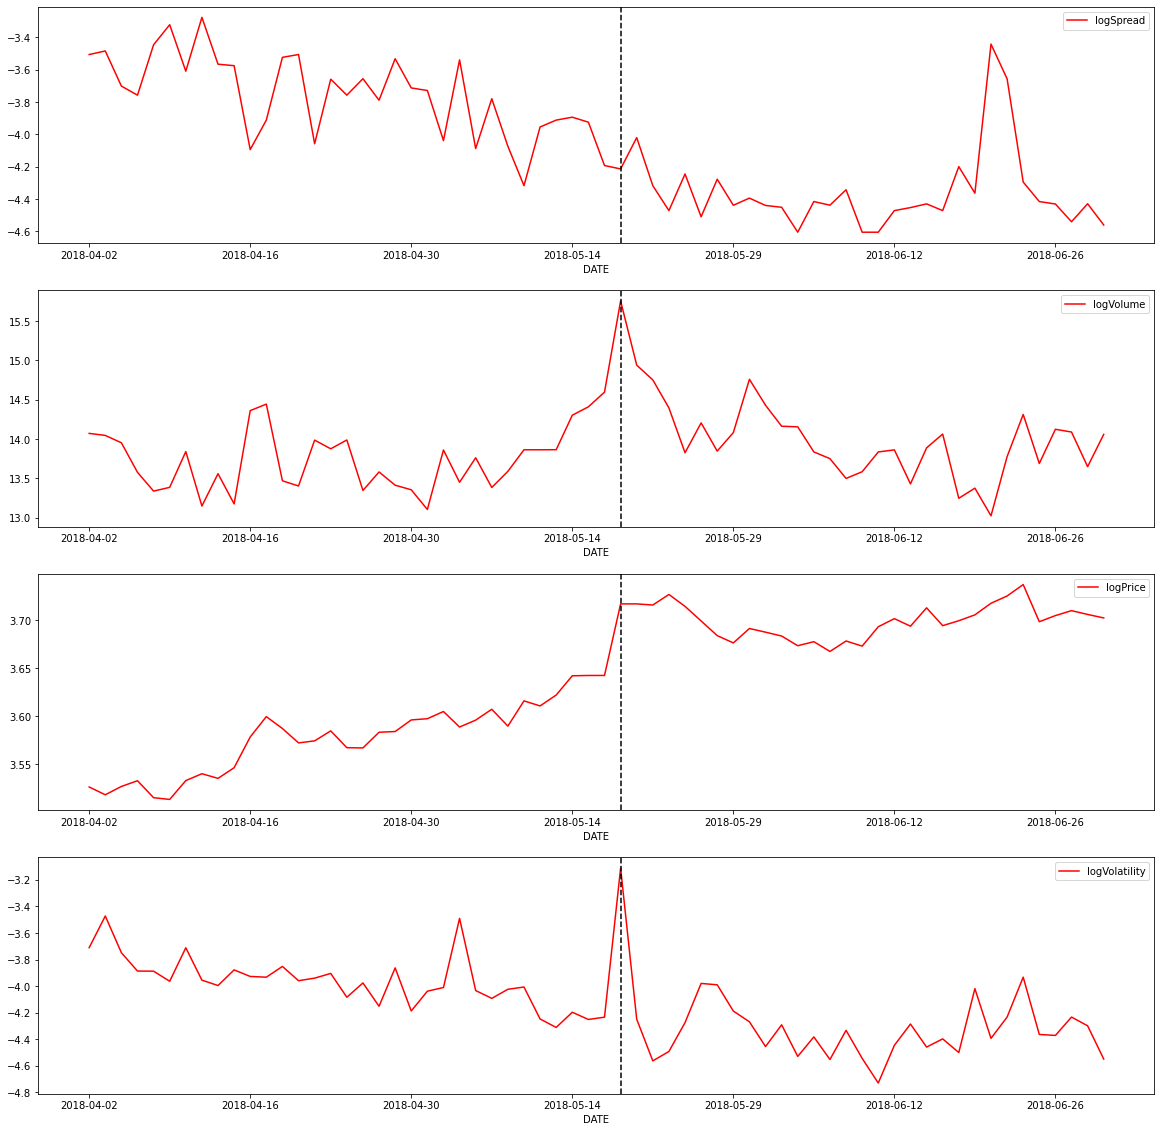

In [99]:
#Stock
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroup.xs('WPZ').plot(y='logOfSpread',ax=a[0],label='logSpread',color='r')
a[0].axvline(WPZ_DT, color='k', linestyle='--')
dfTARGroup.xs('WPZ').plot(y='logShareVolume',ax=a[1],label='logVolume',color='r')
a[1].axvline(WPZ_DT, color='k', linestyle='--')
dfTARGroup.xs('WPZ').plot(y='logPrice',ax=a[2],label='logPrice',color='r')
a[2].axvline(WPZ_DT, color='k', linestyle='--')
dfTARGroup.xs('WPZ').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='r')
a[3].axvline(WPZ_DT, color='k', linestyle='--')

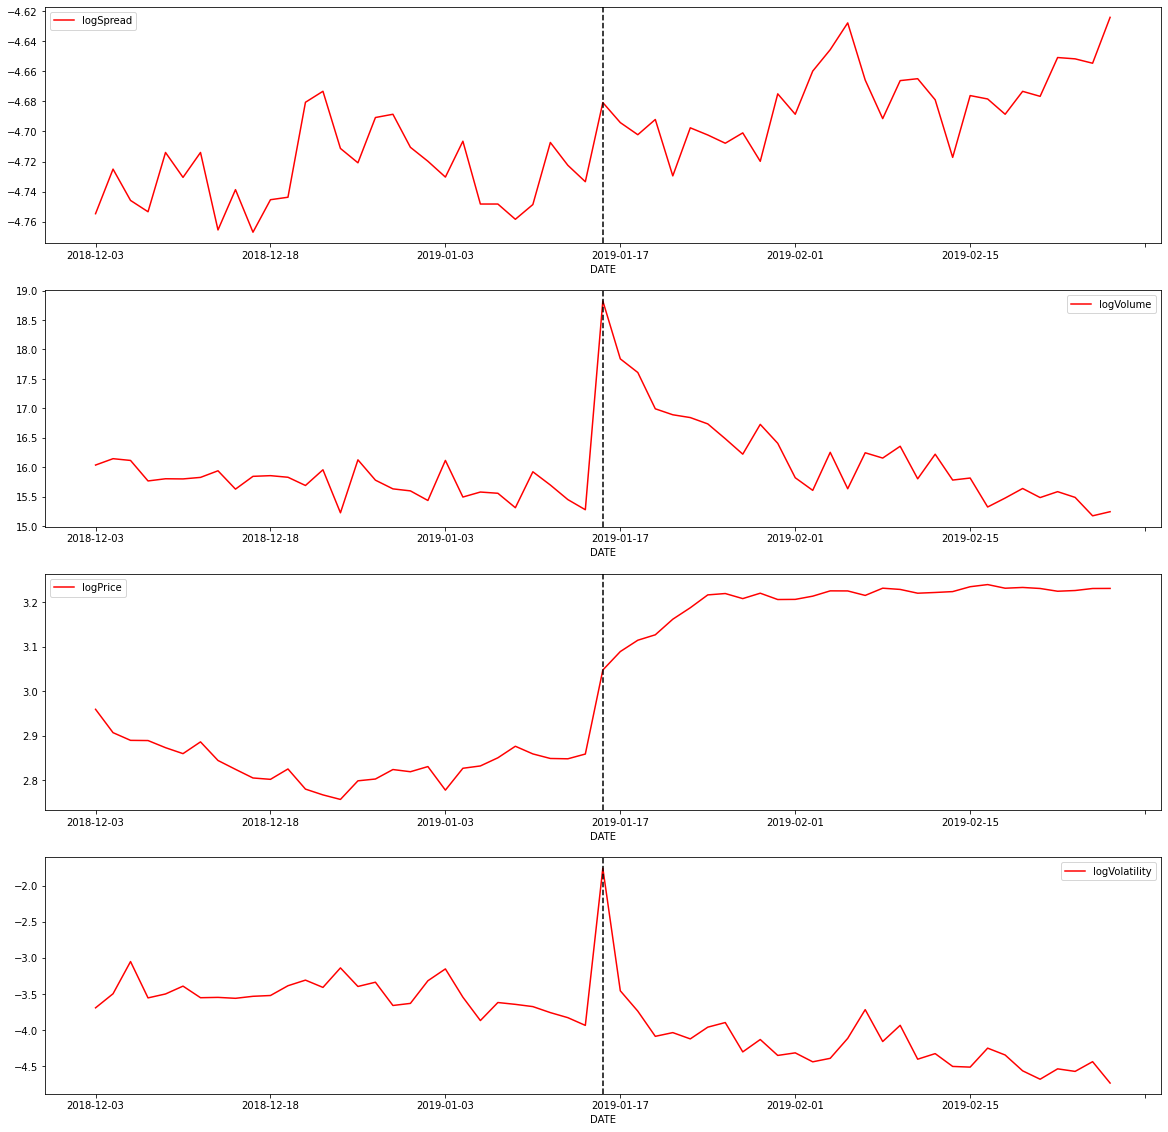

In [100]:
#Stock
f, a = plt.subplots(4,1,figsize=(20,20))
dfTARGroup.xs('FDC').plot(y='logOfSpread',ax=a[0],label='logSpread',color='r')
a[0].axvline(FDC_DT, color='k', linestyle='--')
dfTARGroup.xs('FDC').plot(y='logShareVolume',ax=a[1],label='logVolume',color='r')
a[1].axvline(FDC_DT, color='k', linestyle='--')
dfTARGroup.xs('FDC').plot(y='logPrice',ax=a[2],label='logPrice',color='r')
a[2].axvline(FDC_DT, color='k', linestyle='--')
dfTARGroup.xs('FDC').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='r')
a[3].axvline(FDC_DT, color='k', linestyle='--')

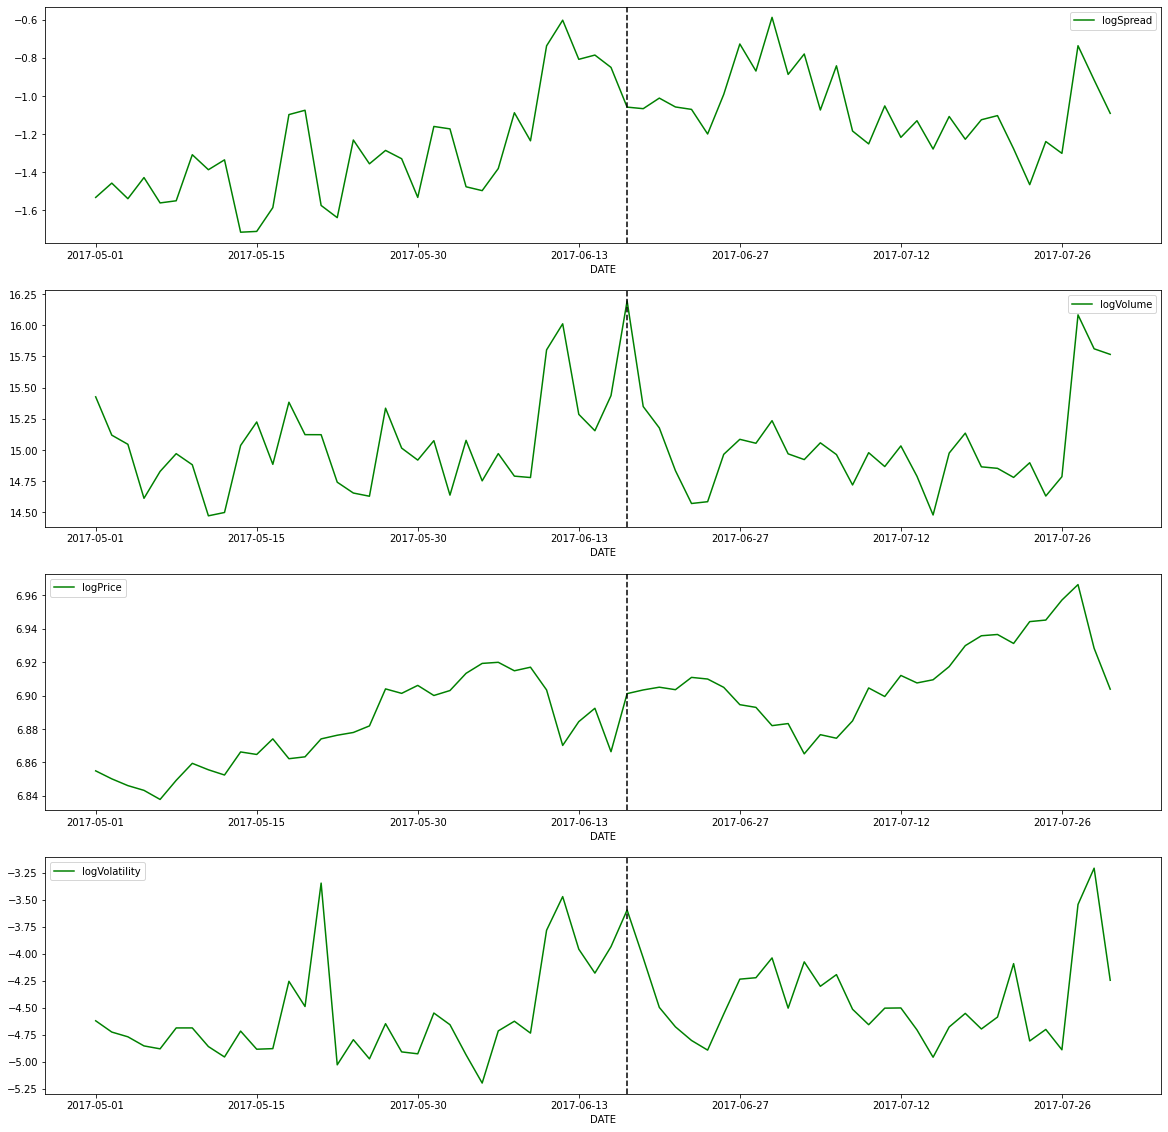

In [101]:
# Cash ACQ
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroup.xs('AMZN').plot(y='logOfSpread',ax=a[0],label='logSpread',color='g')
a[0].axvline(AMZN_DT, color='k', linestyle='--')
dfACQGroup.xs('AMZN').plot(y='logShareVolume',ax=a[1],label='logVolume',color='g')
a[1].axvline(AMZN_DT, color='k', linestyle='--')
dfACQGroup.xs('AMZN').plot(y='logPrice',ax=a[2],label='logPrice',color='g')
a[2].axvline(AMZN_DT, color='k', linestyle='--')
dfACQGroup.xs('AMZN').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='g')
a[3].axvline(AMZN_DT, color='k', linestyle='--')

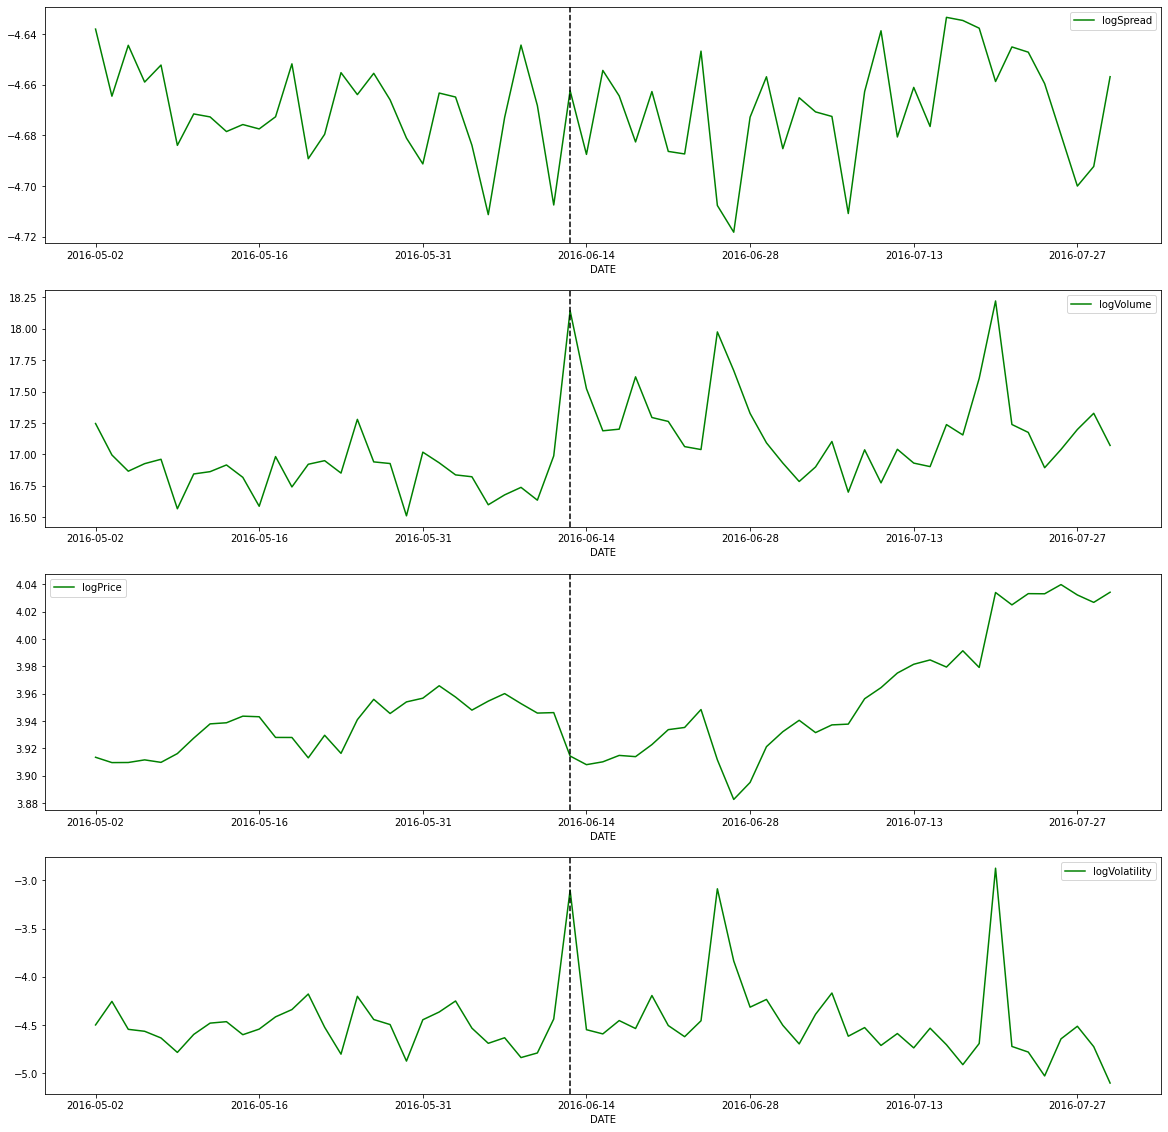

In [102]:
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroup.xs('MSFT').plot(y='logOfSpread',ax=a[0],label='logSpread',color='g')
a[0].axvline(MSFT_DT, color='k', linestyle='--')
dfACQGroup.xs('MSFT').plot(y='logShareVolume',ax=a[1],label='logVolume',color='g')
a[1].axvline(MSFT_DT, color='k', linestyle='--')
dfACQGroup.xs('MSFT').plot(y='logPrice',ax=a[2],label='logPrice',color='g')
a[2].axvline(MSFT_DT, color='k', linestyle='--')
dfACQGroup.xs('MSFT').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='g')
a[3].axvline(MSFT_DT, color='k', linestyle='--')

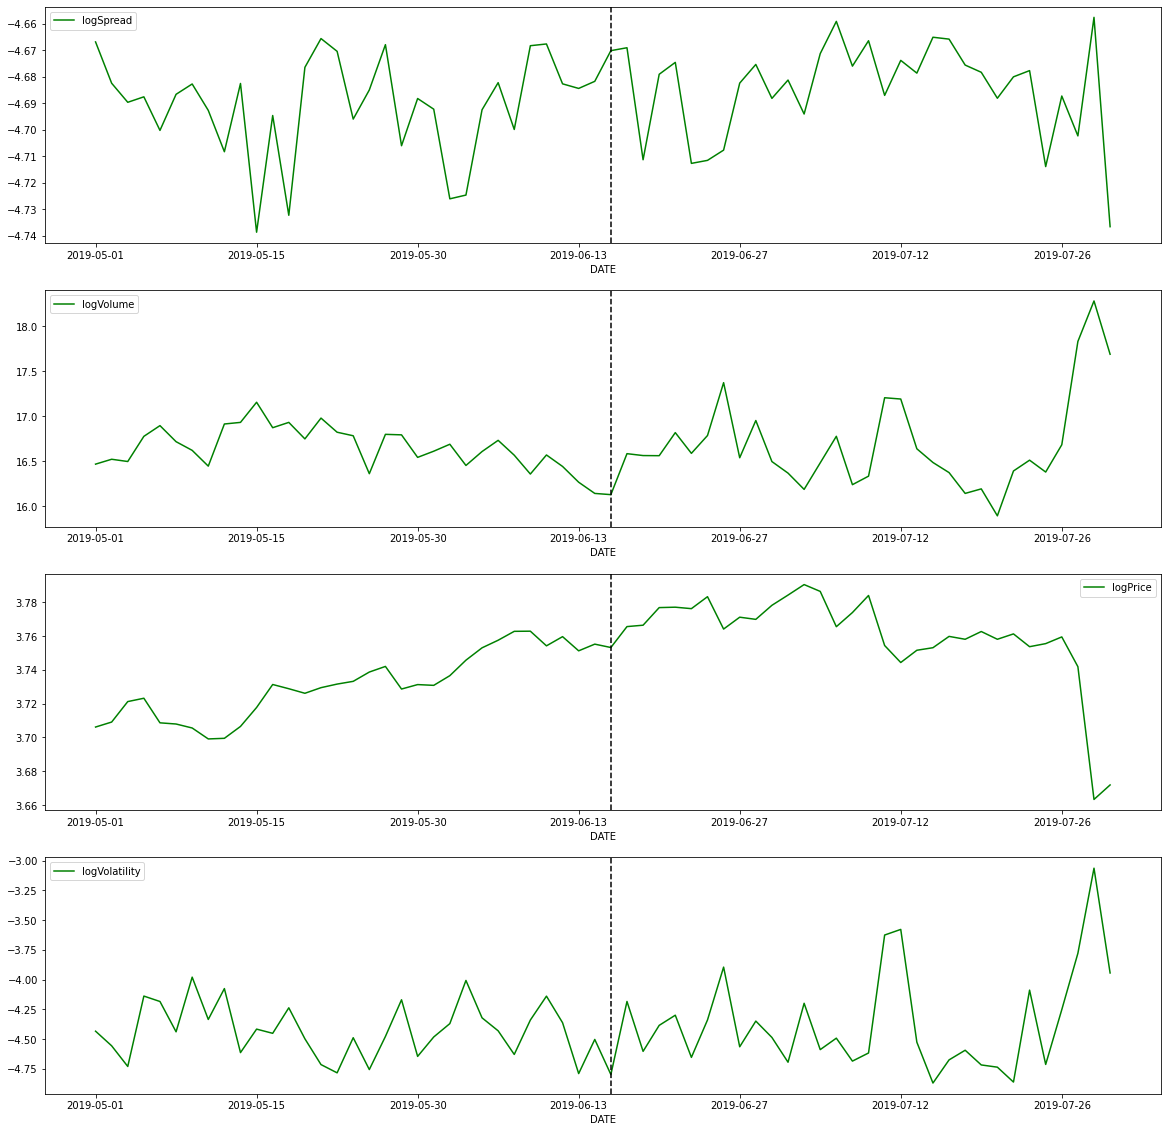

In [103]:
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroup.xs('PFE').plot(y='logOfSpread',ax=a[0],label='logSpread',color='g')
a[0].axvline(PFE_DT, color='k', linestyle='--')
dfACQGroup.xs('PFE').plot(y='logShareVolume',ax=a[1],label='logVolume',color='g')
a[1].axvline(PFE_DT, color='k', linestyle='--')
dfACQGroup.xs('PFE').plot(y='logPrice',ax=a[2],label='logPrice',color='g')
a[2].axvline(PFE_DT, color='k', linestyle='--')
dfACQGroup.xs('PFE').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='g')
a[3].axvline(PFE_DT, color='k', linestyle='--')

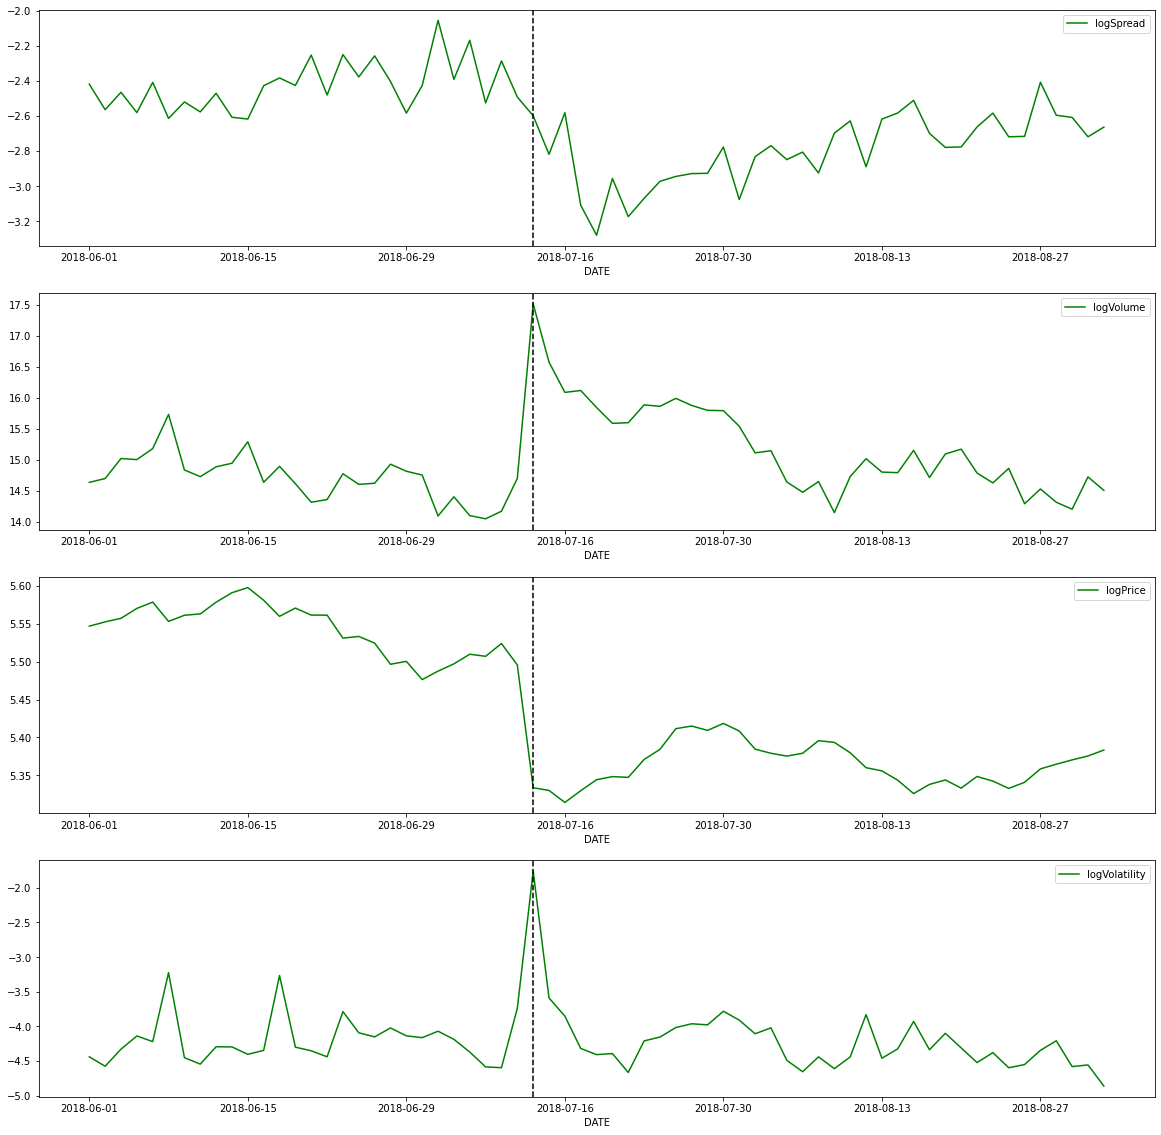

In [104]:
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroup.xs('AVGO').plot(y='logOfSpread',ax=a[0],label='logSpread',color='g')
a[0].axvline(AVGO_DT, color='k', linestyle='--')
dfACQGroup.xs('AVGO').plot(y='logShareVolume',ax=a[1],label='logVolume',color='g')
a[1].axvline(AVGO_DT, color='k', linestyle='--')
dfACQGroup.xs('AVGO').plot(y='logPrice',ax=a[2],label='logPrice',color='g')
a[2].axvline(AVGO_DT, color='k', linestyle='--')
dfACQGroup.xs('AVGO').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='g')
a[3].axvline(AVGO_DT, color='k', linestyle='--')

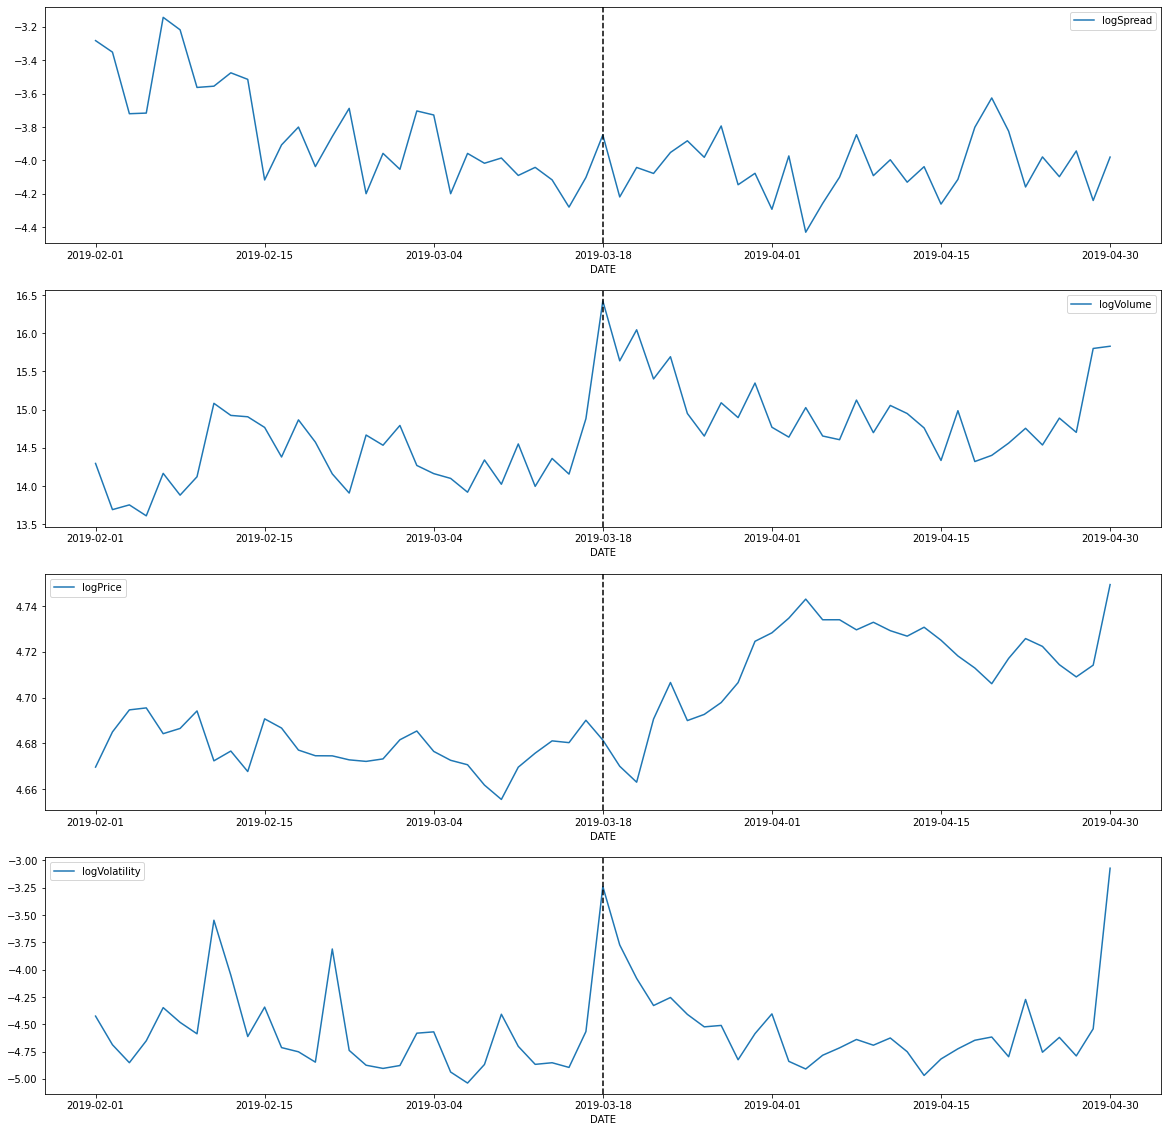

In [105]:
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroup.xs('FIS').plot(y='logOfSpread',ax=a[0],label='logSpread')
a[0].axvline(FIS_DT, color='k', linestyle='--')
dfACQGroup.xs('FIS').plot(y='logShareVolume',ax=a[1],label='logVolume')
a[1].axvline(FIS_DT, color='k', linestyle='--')
dfACQGroup.xs('FIS').plot(y='logPrice',ax=a[2],label='logPrice')
a[2].axvline(FIS_DT, color='k', linestyle='--')
dfACQGroup.xs('FIS').plot(y='logDayVolatility',ax=a[3],label='logVolatility')
a[3].axvline(FIS_DT, color='k', linestyle='--')

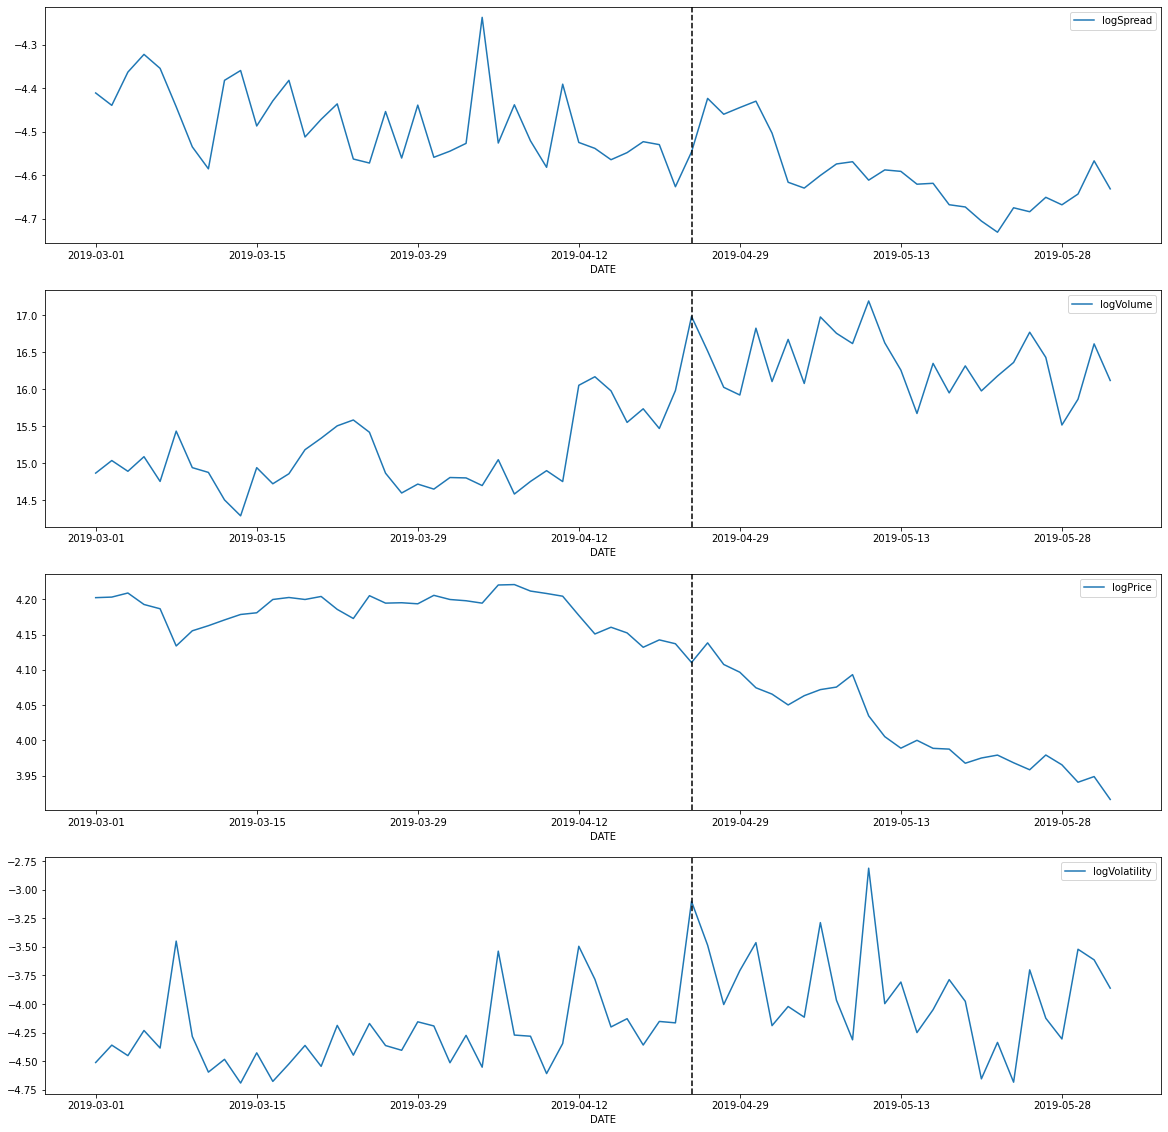

In [106]:
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroup.xs('OXY').plot(y='logOfSpread',ax=a[0],label='logSpread')
a[0].axvline(OXY_DT, color='k', linestyle='--')
dfACQGroup.xs('OXY').plot(y='logShareVolume',ax=a[1],label='logVolume')
a[1].axvline(OXY_DT, color='k', linestyle='--')
dfACQGroup.xs('OXY').plot(y='logPrice',ax=a[2],label='logPrice')
a[2].axvline(OXY_DT, color='k', linestyle='--')
dfACQGroup.xs('OXY').plot(y='logDayVolatility',ax=a[3],label='logVolatility')
a[3].axvline(OXY_DT, color='k', linestyle='--')

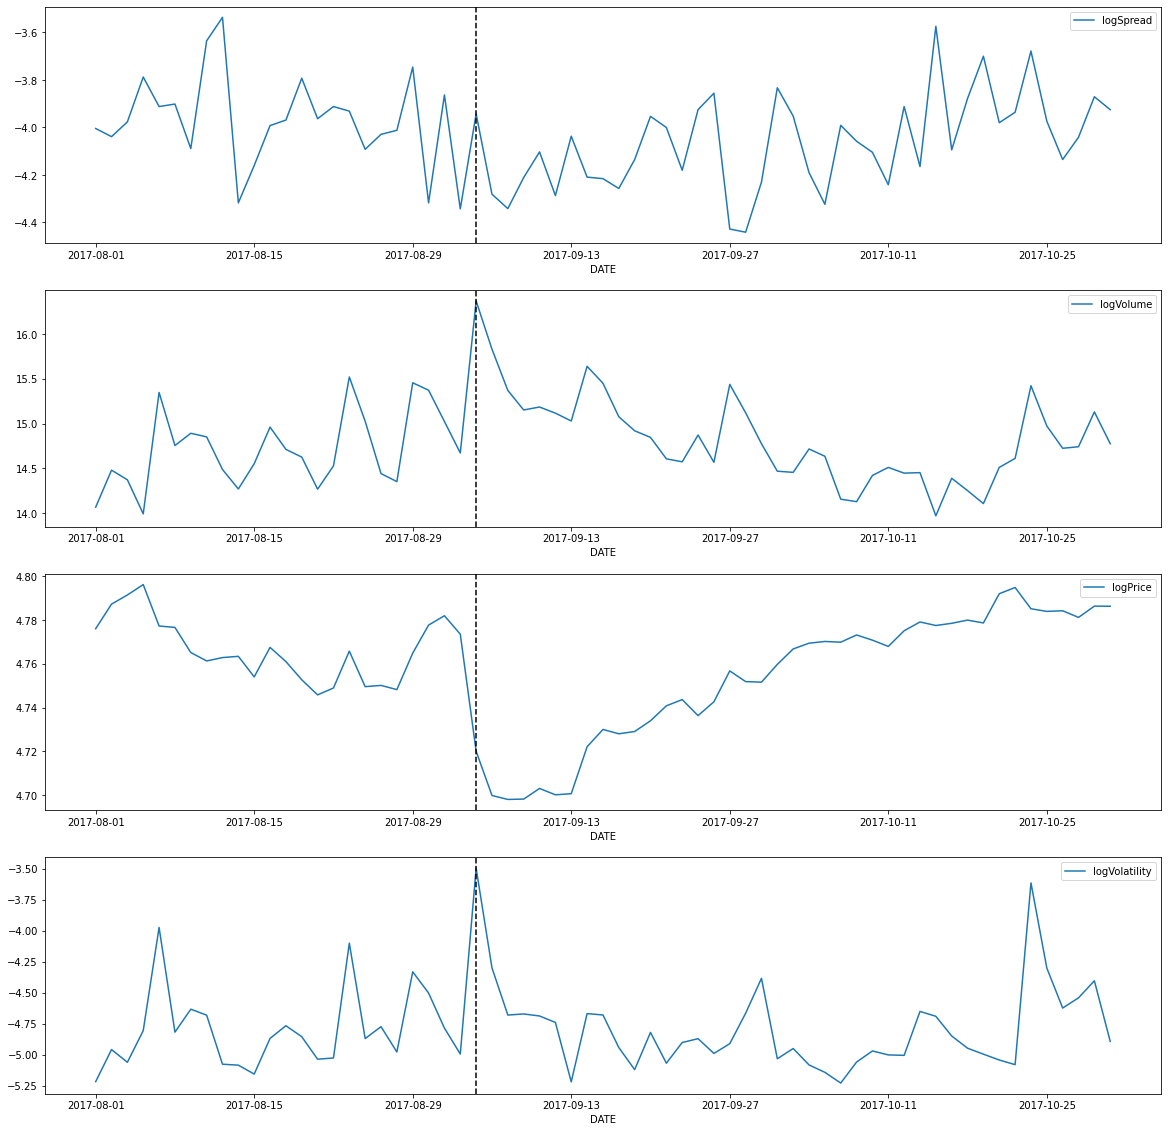

In [107]:
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroup.xs('UTX').plot(y='logOfSpread',ax=a[0],label='logSpread')
a[0].axvline(UTX_DT, color='k', linestyle='--')
dfACQGroup.xs('UTX').plot(y='logShareVolume',ax=a[1],label='logVolume')
a[1].axvline(UTX_DT, color='k', linestyle='--')
dfACQGroup.xs('UTX').plot(y='logPrice',ax=a[2],label='logPrice')
a[2].axvline(UTX_DT, color='k', linestyle='--')
dfACQGroup.xs('UTX').plot(y='logDayVolatility',ax=a[3],label='logVolatility')
a[3].axvline(UTX_DT, color='k', linestyle='--')

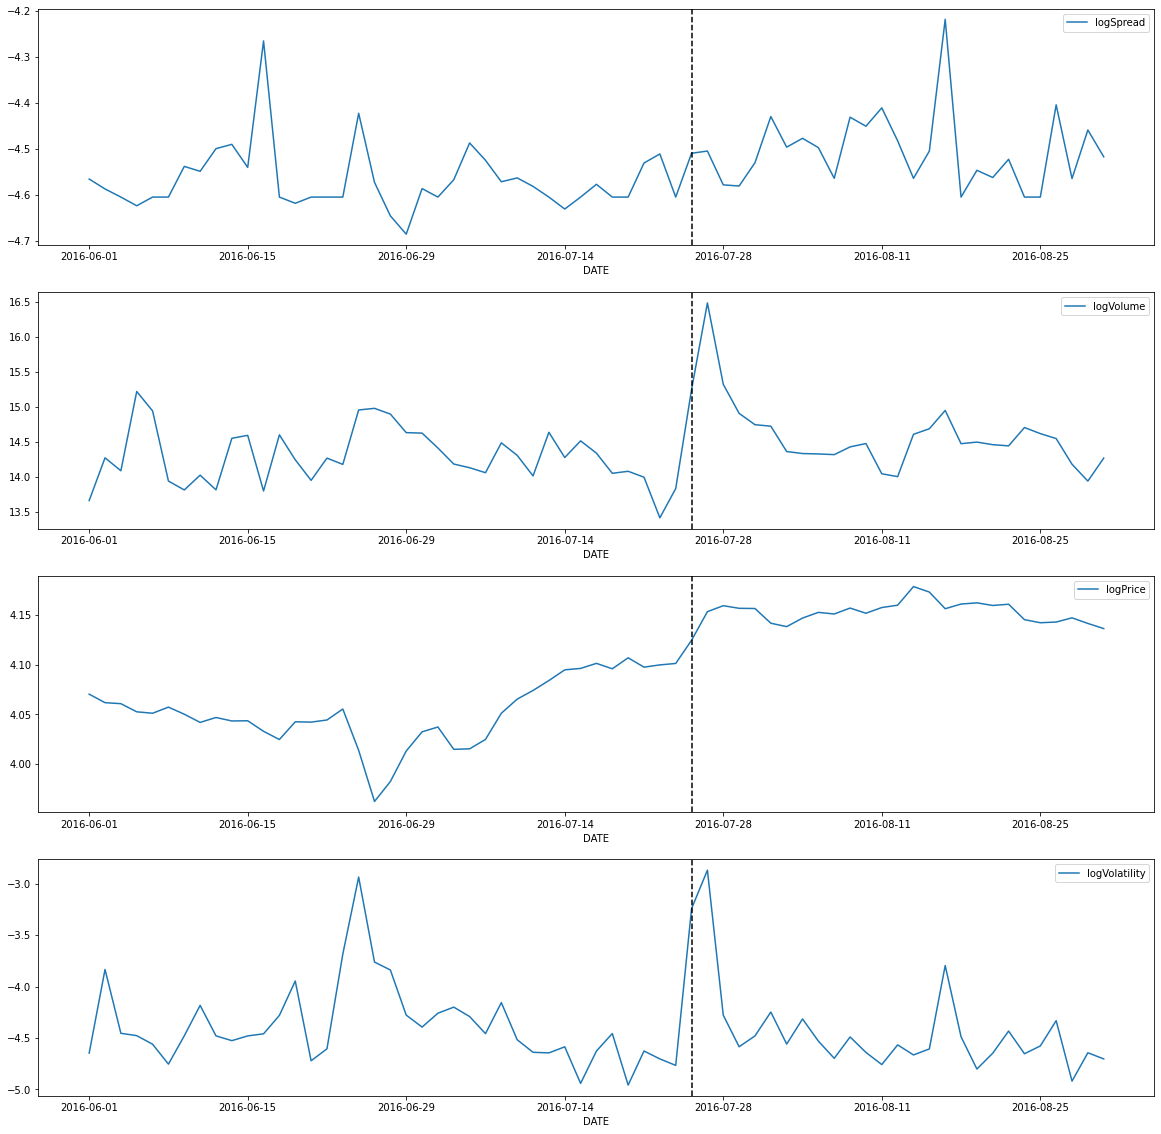

In [108]:
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroup.xs('ADI').plot(y='logOfSpread',ax=a[0],label='logSpread')
a[0].axvline(ADI_DT, color='k', linestyle='--')
dfACQGroup.xs('ADI').plot(y='logShareVolume',ax=a[1],label='logVolume')
a[1].axvline(ADI_DT, color='k', linestyle='--')
dfACQGroup.xs('ADI').plot(y='logPrice',ax=a[2],label='logPrice')
a[2].axvline(ADI_DT, color='k', linestyle='--')
dfACQGroup.xs('ADI').plot(y='logDayVolatility',ax=a[3],label='logVolatility')
a[3].axvline(ADI_DT, color='k', linestyle='--')

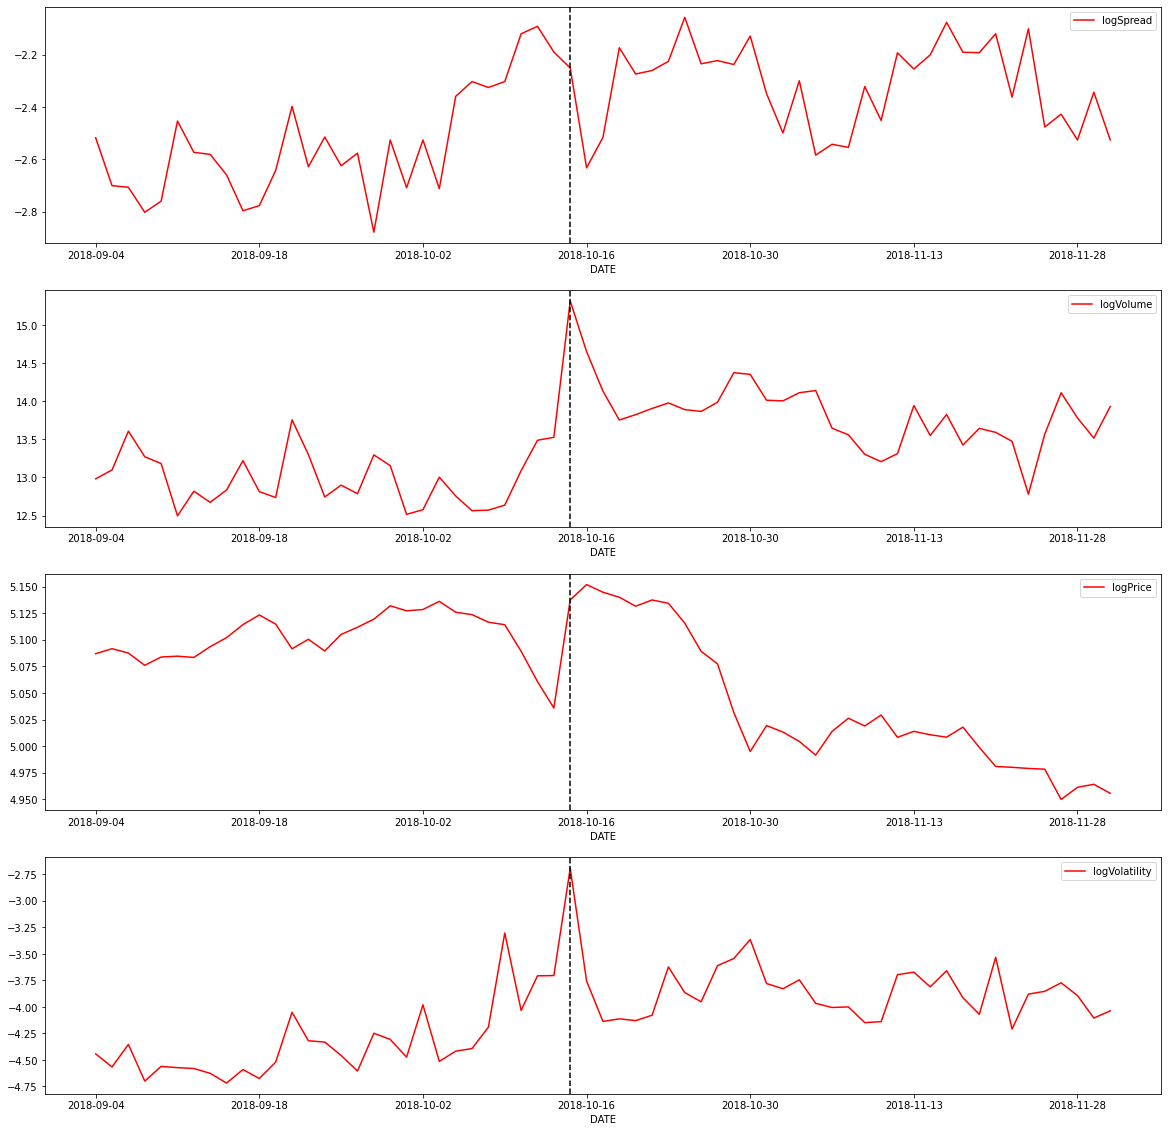

In [109]:
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroup.xs('HRS').plot(y='logOfSpread',ax=a[0],label='logSpread',color='r')
a[0].axvline(HRS_DT, color='k', linestyle='--')
dfACQGroup.xs('HRS').plot(y='logShareVolume',ax=a[1],label='logVolume',color='r')
a[1].axvline(HRS_DT, color='k', linestyle='--')
dfACQGroup.xs('HRS').plot(y='logPrice',ax=a[2],label='logPrice',color='r')
a[2].axvline(HRS_DT, color='k', linestyle='--')
dfACQGroup.xs('HRS').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='r')
a[3].axvline(HRS_DT, color='k', linestyle='--')

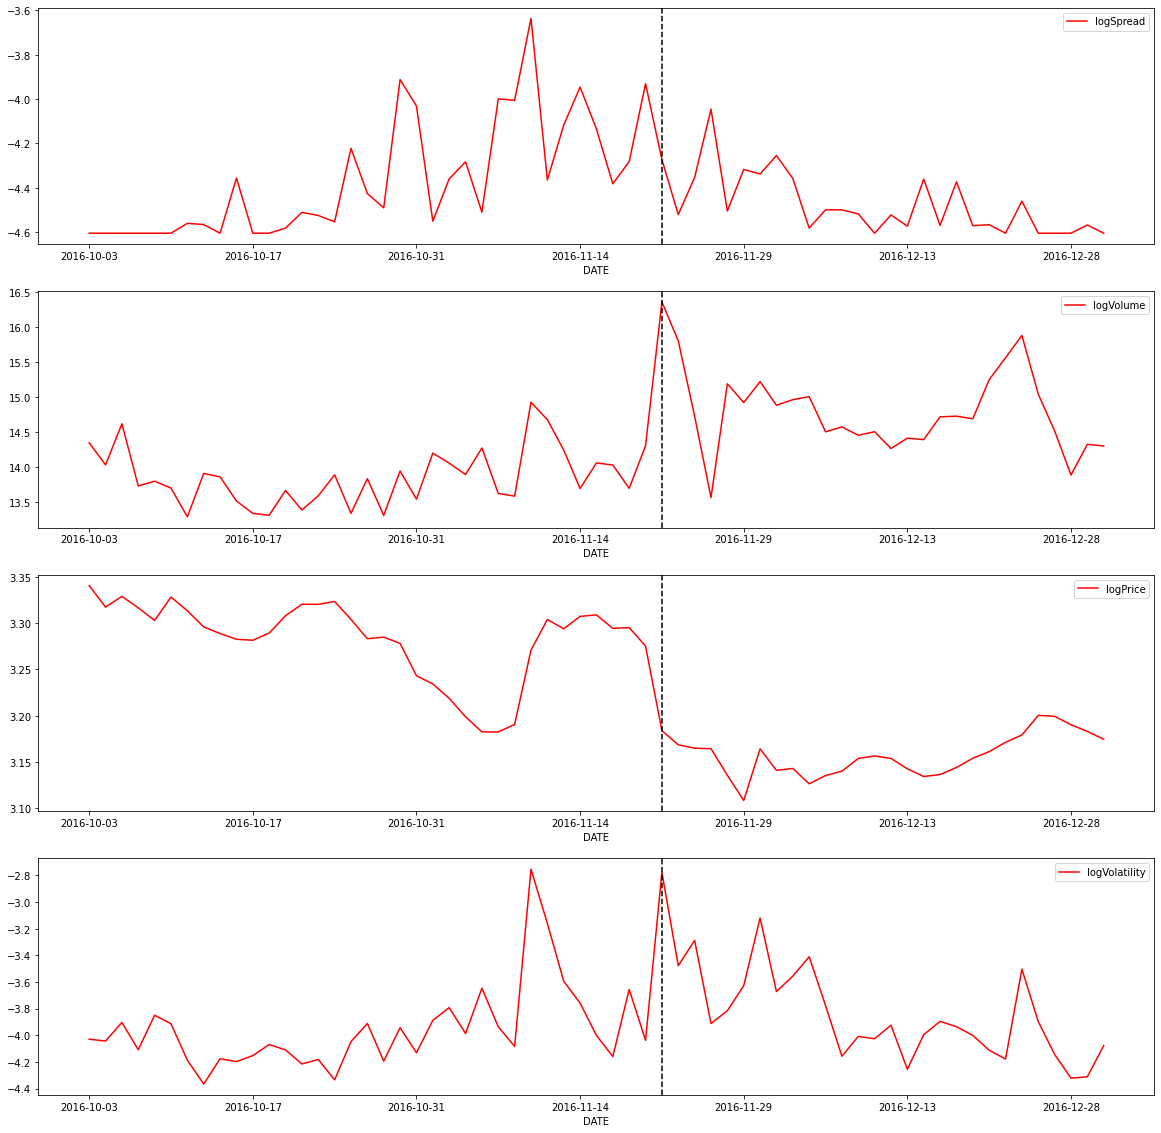

In [110]:
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroup.xs('SXL').plot(y='logOfSpread',ax=a[0],label='logSpread',color='r')
a[0].axvline(SXL_DT, color='k', linestyle='--')
dfACQGroup.xs('SXL').plot(y='logShareVolume',ax=a[1],label='logVolume',color='r')
a[1].axvline(SXL_DT, color='k', linestyle='--')
dfACQGroup.xs('SXL').plot(y='logPrice',ax=a[2],label='logPrice',color='r')
a[2].axvline(SXL_DT, color='k', linestyle='--')
dfACQGroup.xs('SXL').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='r')
a[3].axvline(SXL_DT, color='k', linestyle='--')

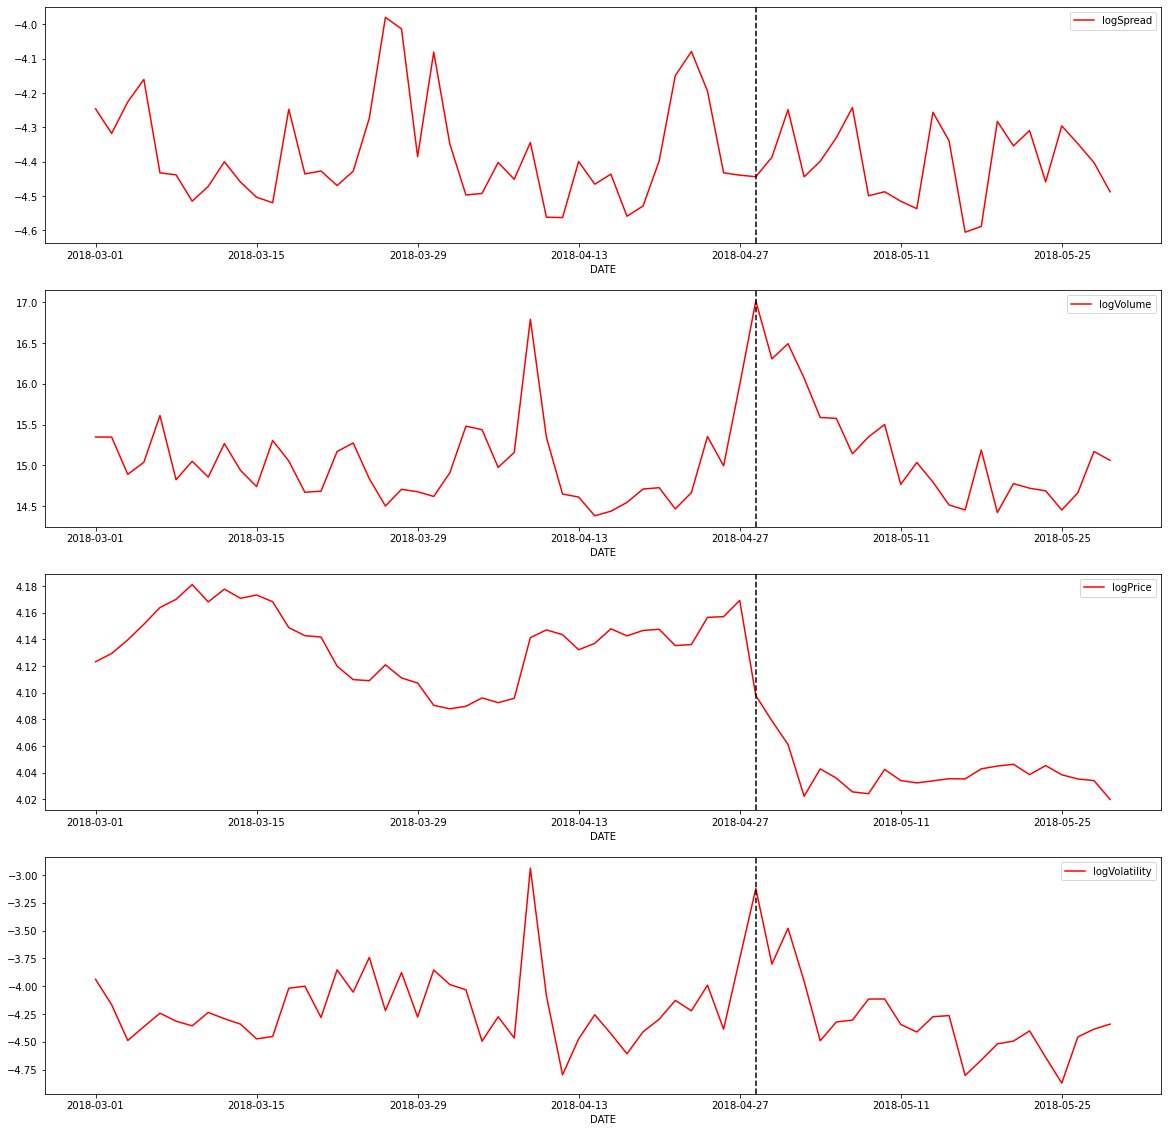

In [111]:
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroup.xs('TMUS').plot(y='logOfSpread',ax=a[0],label='logSpread',color='r')
a[0].axvline(TMUS_DT, color='k', linestyle='--')
dfACQGroup.xs('TMUS').plot(y='logShareVolume',ax=a[1],label='logVolume',color='r')
a[1].axvline(TMUS_DT, color='k', linestyle='--')
dfACQGroup.xs('TMUS').plot(y='logPrice',ax=a[2],label='logPrice',color='r')
a[2].axvline(TMUS_DT, color='k', linestyle='--')
dfACQGroup.xs('TMUS').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='r')
a[3].axvline(TMUS_DT, color='k', linestyle='--')

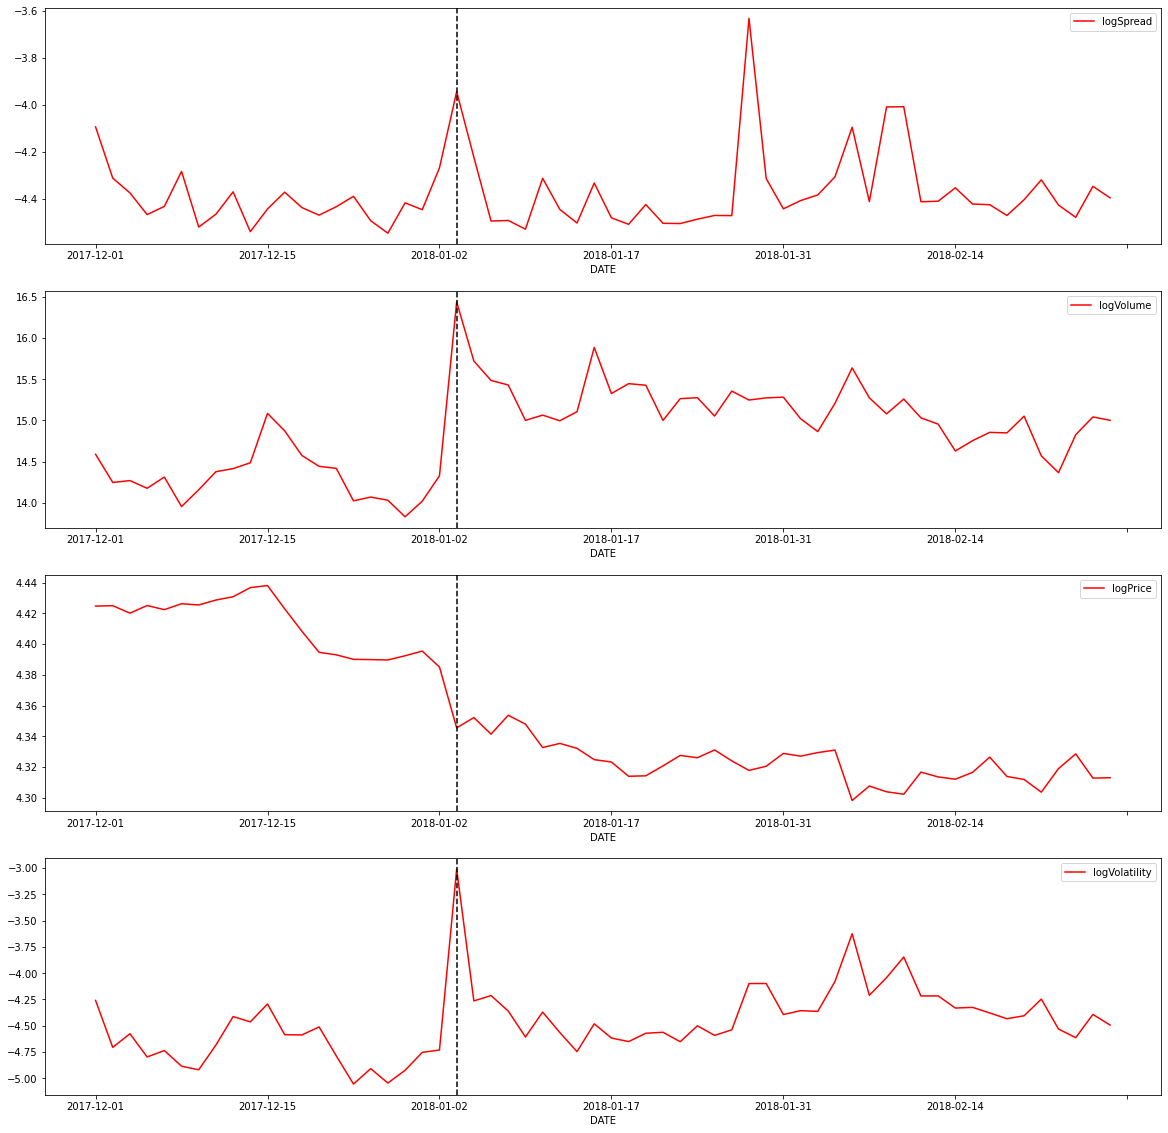

In [112]:
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroup.xs('D').plot(y='logOfSpread',ax=a[0],label='logSpread',color='r')
a[0].axvline(D_DT, color='k', linestyle='--')
dfACQGroup.xs('D').plot(y='logShareVolume',ax=a[1],label='logVolume',color='r')
a[1].axvline(D_DT, color='k', linestyle='--')
dfACQGroup.xs('D').plot(y='logPrice',ax=a[2],label='logPrice',color='r')
a[2].axvline(D_DT, color='k', linestyle='--')
dfACQGroup.xs('D').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='r')
a[3].axvline(D_DT, color='k', linestyle='--')

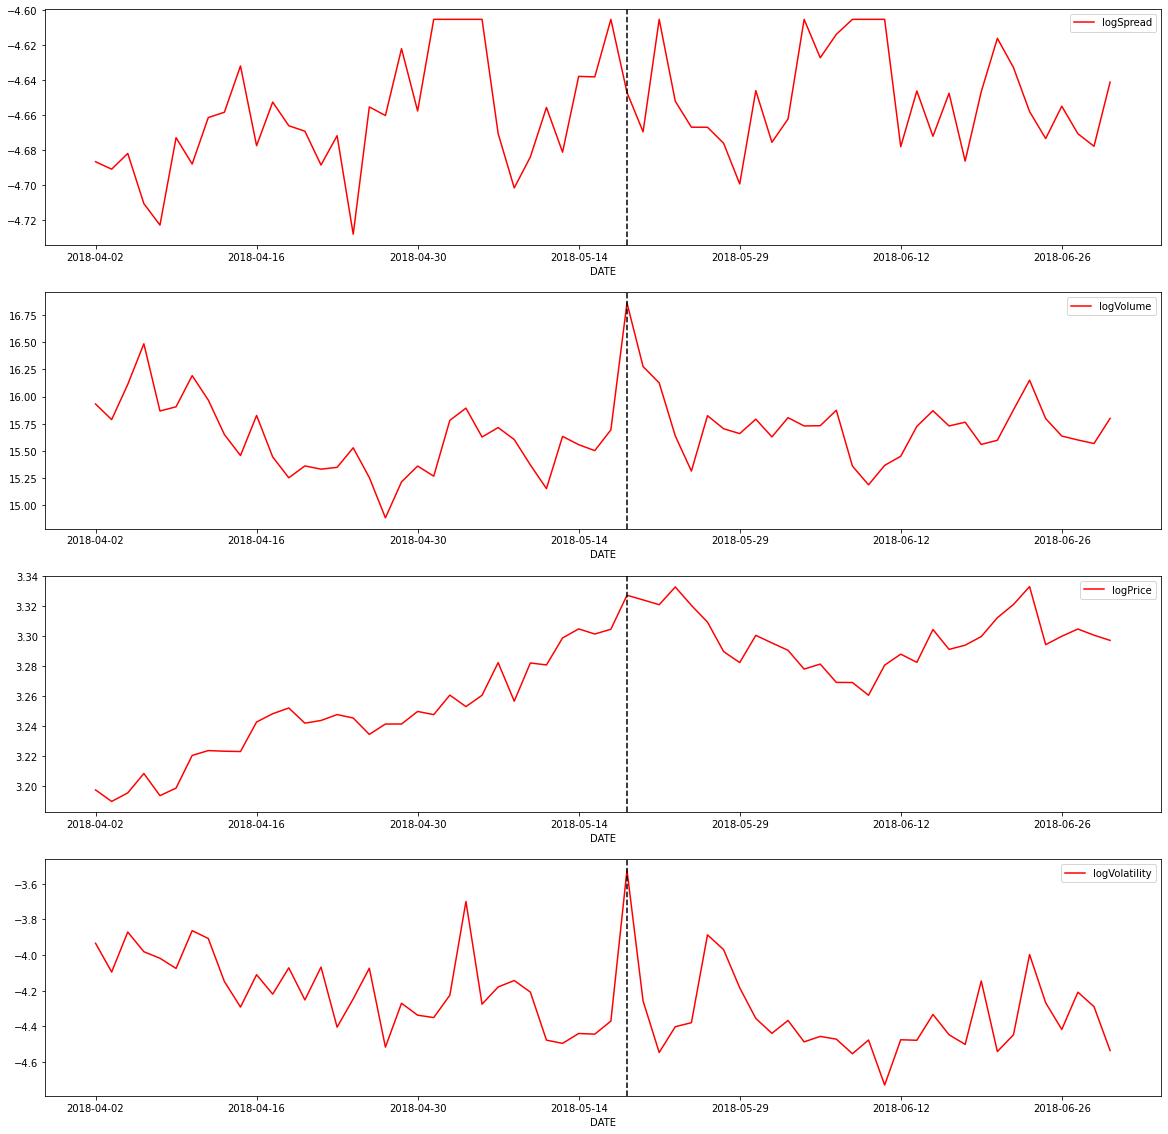

In [113]:
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroup.xs('WMB').plot(y='logOfSpread',ax=a[0],label='logSpread',color='r')
a[0].axvline(WMB_DT, color='k', linestyle='--')
dfACQGroup.xs('WMB').plot(y='logShareVolume',ax=a[1],label='logVolume',color='r')
a[1].axvline(WMB_DT, color='k', linestyle='--')
dfACQGroup.xs('WMB').plot(y='logPrice',ax=a[2],label='logPrice',color='r')
a[2].axvline(WMB_DT, color='k', linestyle='--')
dfACQGroup.xs('WMB').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='r')
a[3].axvline(WMB_DT, color='k', linestyle='--')

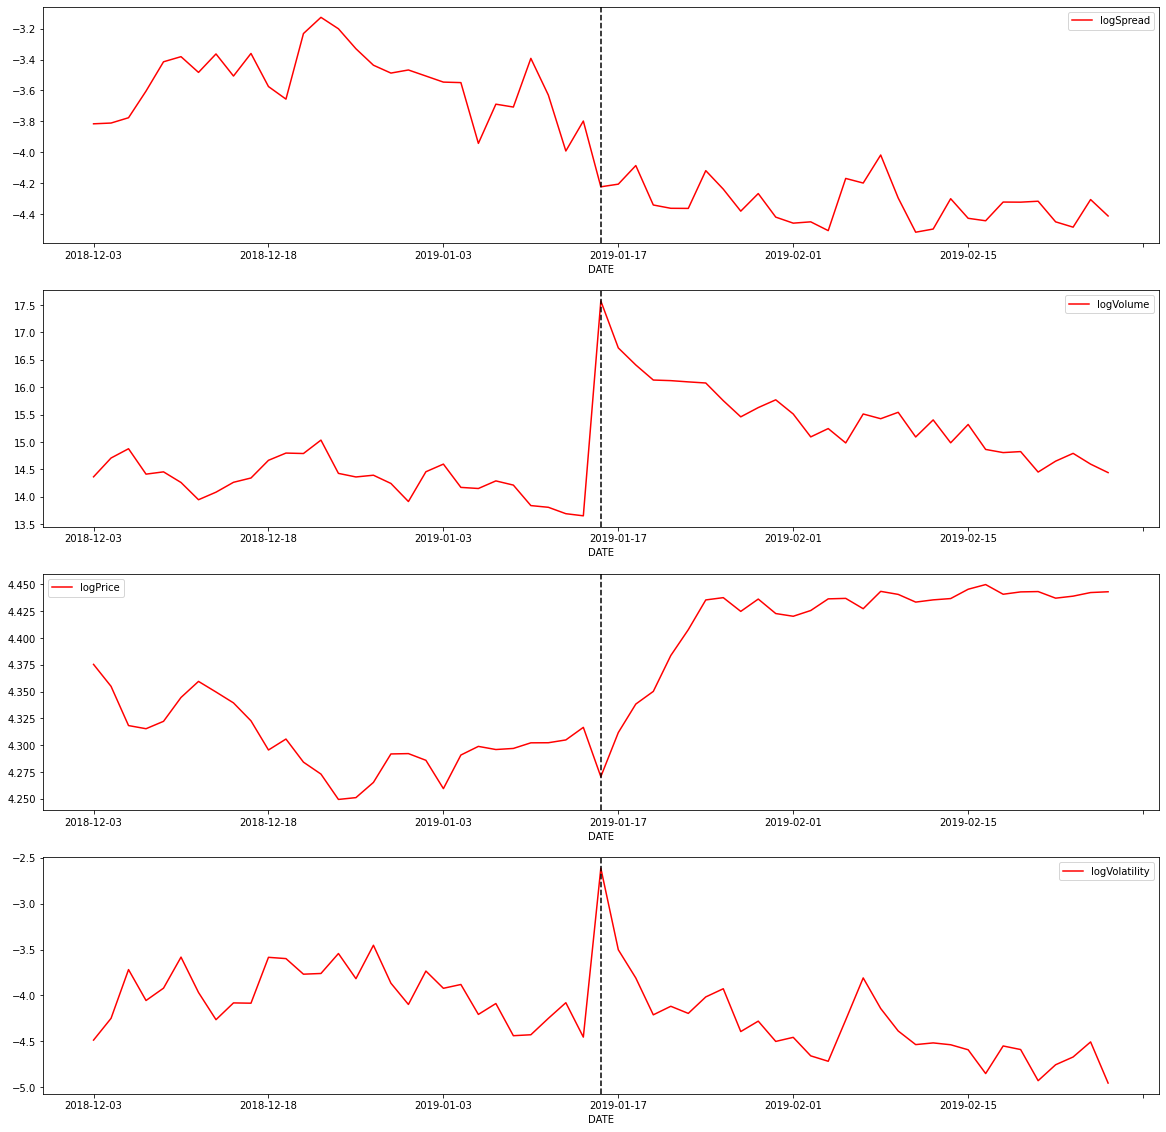

In [114]:
f, a = plt.subplots(4,1,figsize=(20,20))
dfACQGroup.xs('FISV').plot(y='logOfSpread',ax=a[0],label='logSpread',color='r')
a[0].axvline(FISV_DT, color='k', linestyle='--')
dfACQGroup.xs('FISV').plot(y='logShareVolume',ax=a[1],label='logVolume',color='r')
a[1].axvline(FISV_DT, color='k', linestyle='--')
dfACQGroup.xs('FISV').plot(y='logPrice',ax=a[2],label='logPrice',color='r')
a[2].axvline(FISV_DT, color='k', linestyle='--')
dfACQGroup.xs('FISV').plot(y='logDayVolatility',ax=a[3],label='logVolatility',color='r')
a[3].axvline(FISV_DT, color='k', linestyle='--')

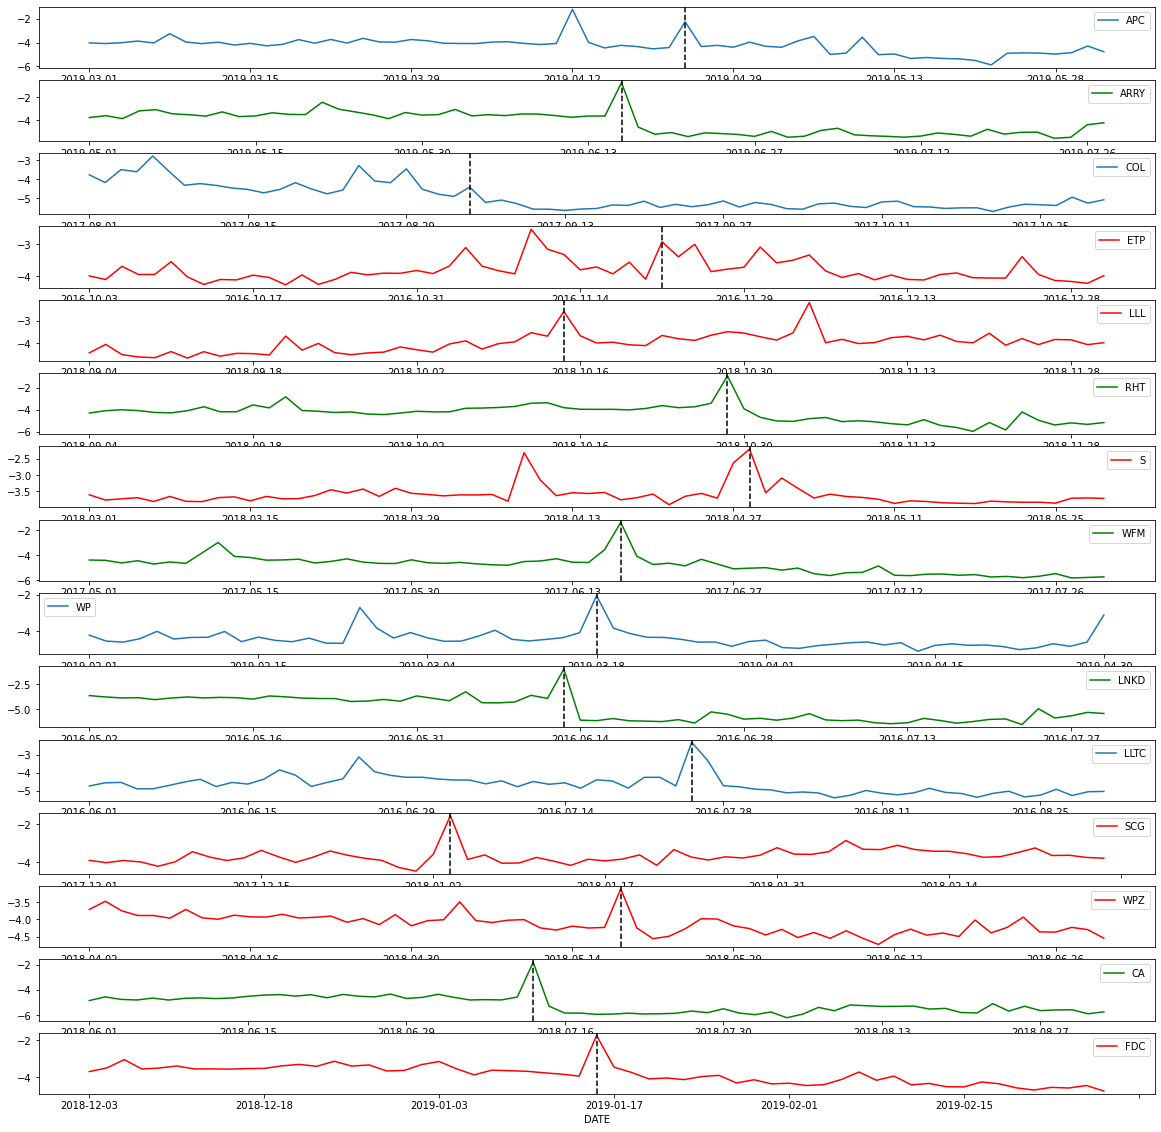

In [15]:
# Plot of logDayVolatility over time for TAR by company
f, a = plt.subplots(15,1,figsize=(20,20))
dfTARGroup.xs('APC').plot(y='logDayVolatility',ax=a[0],label='APC')
a[0].axvline(APC_DT, color='k', linestyle='--')

dfTARGroup.xs('ARRY').plot(y='logDayVolatility',ax=a[1],label='ARRY',color='g')
a[1].axvline(ARRY_DT, color='k', linestyle='--')

dfTARGroup.xs('COL').plot(y='logDayVolatility',ax=a[2],label='COL')
a[2].axvline(COL_DT, color='k', linestyle='--')

dfTARGroup.xs('ETP').plot(y='logDayVolatility',ax=a[3],label='ETP',color='r')
a[3].axvline(ETP_DT, color='k', linestyle='--')

dfTARGroup.xs('LLL').plot(y='logDayVolatility',ax=a[4],label='LLL',color='r')
a[4].axvline(LLL_DT, color='k', linestyle='--')

dfTARGroup.xs('RHT').plot(y='logDayVolatility',ax=a[5],label='RHT',color='g')
a[5].axvline(RHT_DT, color='k', linestyle='--')

dfTARGroup.xs('S').plot(y='logDayVolatility',ax=a[6],label='S',color='r')
a[6].axvline(S_DT, color='k', linestyle='--')

dfTARGroup.xs('WFM').plot(y='logDayVolatility',ax=a[7],label='WFM',color='g')
a[7].axvline(WFM_DT, color='k', linestyle='--')

dfTARGroup.xs('WP').plot(y='logDayVolatility',ax=a[8],label='WP')
a[8].axvline(WP_DT, color='k', linestyle='--')

dfTARGroup.xs('LNKD').plot(y='logDayVolatility',ax=a[9],label='LNKD',color='g')
a[9].axvline(LNKD_DT, color='k', linestyle='--')

dfTARGroup.xs('LLTC').plot(y='logDayVolatility',ax=a[10],label='LLTC')
a[10].axvline(LLTC_DT, color='k', linestyle='--')

dfTARGroup.xs('SCG').plot(y='logDayVolatility',ax=a[11],label='SCG',color='r')
a[11].axvline(SCG_DT, color='k', linestyle='--')

dfTARGroup.xs('WPZ').plot(y='logDayVolatility',ax=a[12],label='WPZ',color='r')
a[12].axvline(WPZ_DT, color='k', linestyle='--')

dfTARGroup.xs('CA').plot(y='logDayVolatility',ax=a[13],label='CA',color='g')
a[13].axvline(CA_DT, color='k', linestyle='--')

dfTARGroup.xs('FDC').plot(y='logDayVolatility',ax=a[14],label='FDC',color='r')
a[14].axvline(FDC_DT, color='k', linestyle='--')

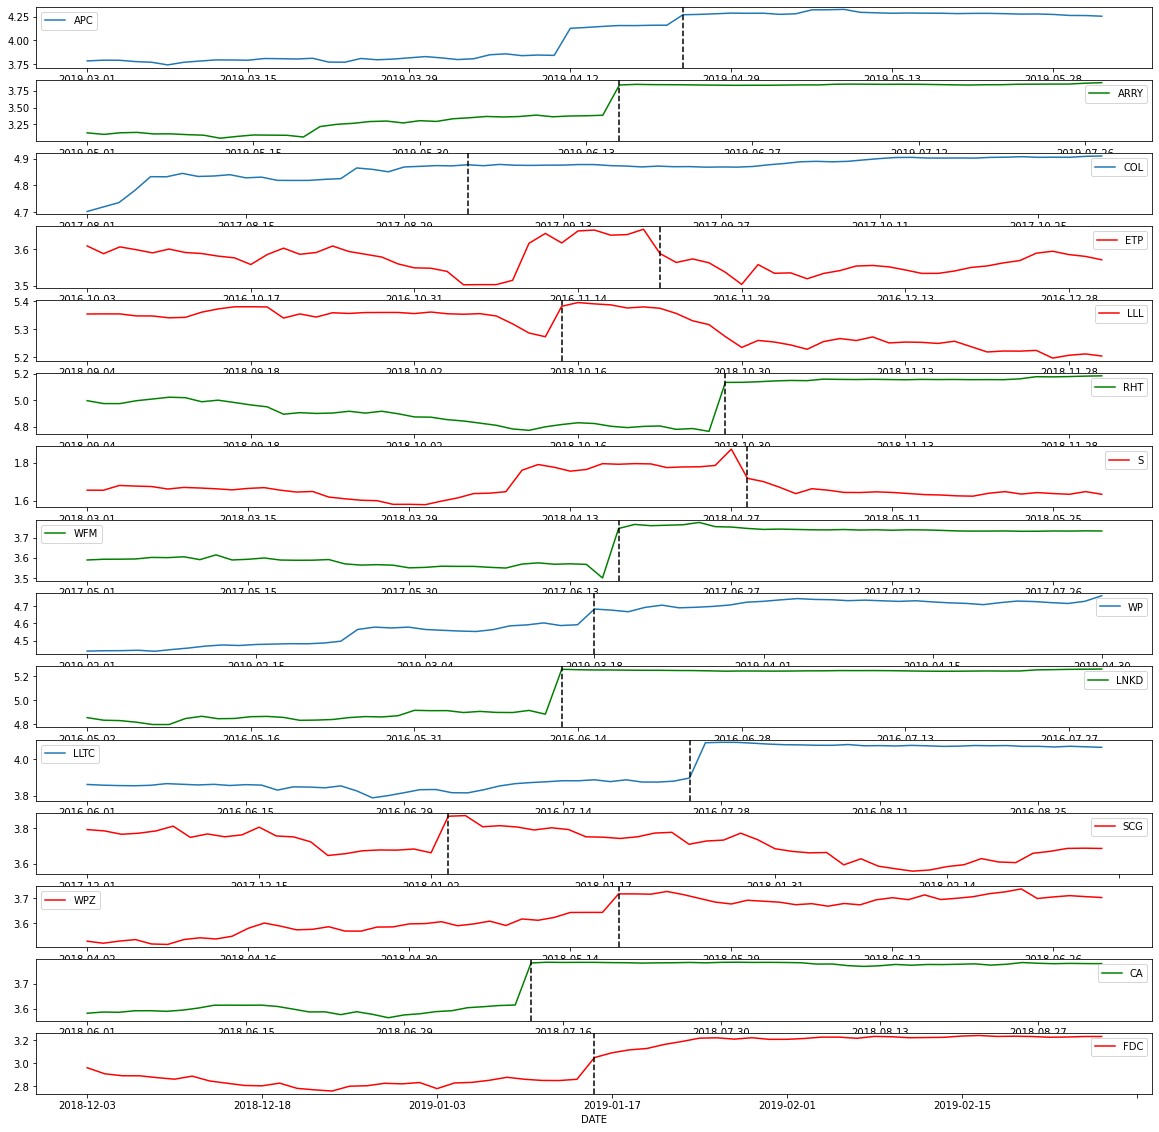

In [16]:
# Plot of logPrice over time for TAR by company
f, a = plt.subplots(15,1,figsize=(20,20))
dfTARGroup.xs('APC').plot(y='logPrice',ax=a[0],label='APC')
a[0].axvline(APC_DT, color='k', linestyle='--')

dfTARGroup.xs('ARRY').plot(y='logPrice',ax=a[1],label='ARRY',color='g')
a[1].axvline(ARRY_DT, color='k', linestyle='--')

dfTARGroup.xs('COL').plot(y='logPrice',ax=a[2],label='COL')
a[2].axvline(COL_DT, color='k', linestyle='--')

dfTARGroup.xs('ETP').plot(y='logPrice',ax=a[3],label='ETP',color='r')
a[3].axvline(ETP_DT, color='k', linestyle='--')

dfTARGroup.xs('LLL').plot(y='logPrice',ax=a[4],label='LLL',color='r')
a[4].axvline(LLL_DT, color='k', linestyle='--')

dfTARGroup.xs('RHT').plot(y='logPrice',ax=a[5],label='RHT',color='g')
a[5].axvline(RHT_DT, color='k', linestyle='--')

dfTARGroup.xs('S').plot(y='logPrice',ax=a[6],label='S',color='r')
a[6].axvline(S_DT, color='k', linestyle='--')

dfTARGroup.xs('WFM').plot(y='logPrice',ax=a[7],label='WFM',color='g')
a[7].axvline(WFM_DT, color='k', linestyle='--')

dfTARGroup.xs('WP').plot(y='logPrice',ax=a[8],label='WP')
a[8].axvline(WP_DT, color='k', linestyle='--')

dfTARGroup.xs('LNKD').plot(y='logPrice',ax=a[9],label='LNKD',color='g')
a[9].axvline(LNKD_DT, color='k', linestyle='--')

dfTARGroup.xs('LLTC').plot(y='logPrice',ax=a[10],label='LLTC')
a[10].axvline(LLTC_DT, color='k', linestyle='--')

dfTARGroup.xs('SCG').plot(y='logPrice',ax=a[11],label='SCG',color='r')
a[11].axvline(SCG_DT, color='k', linestyle='--')

dfTARGroup.xs('WPZ').plot(y='logPrice',ax=a[12],label='WPZ',color='r')
a[12].axvline(WPZ_DT, color='k', linestyle='--')

dfTARGroup.xs('CA').plot(y='logPrice',ax=a[13],label='CA',color='g')
a[13].axvline(CA_DT, color='k', linestyle='--')

dfTARGroup.xs('FDC').plot(y='logPrice',ax=a[14],label='FDC',color='r')
a[14].axvline(FDC_DT, color='k', linestyle='--')

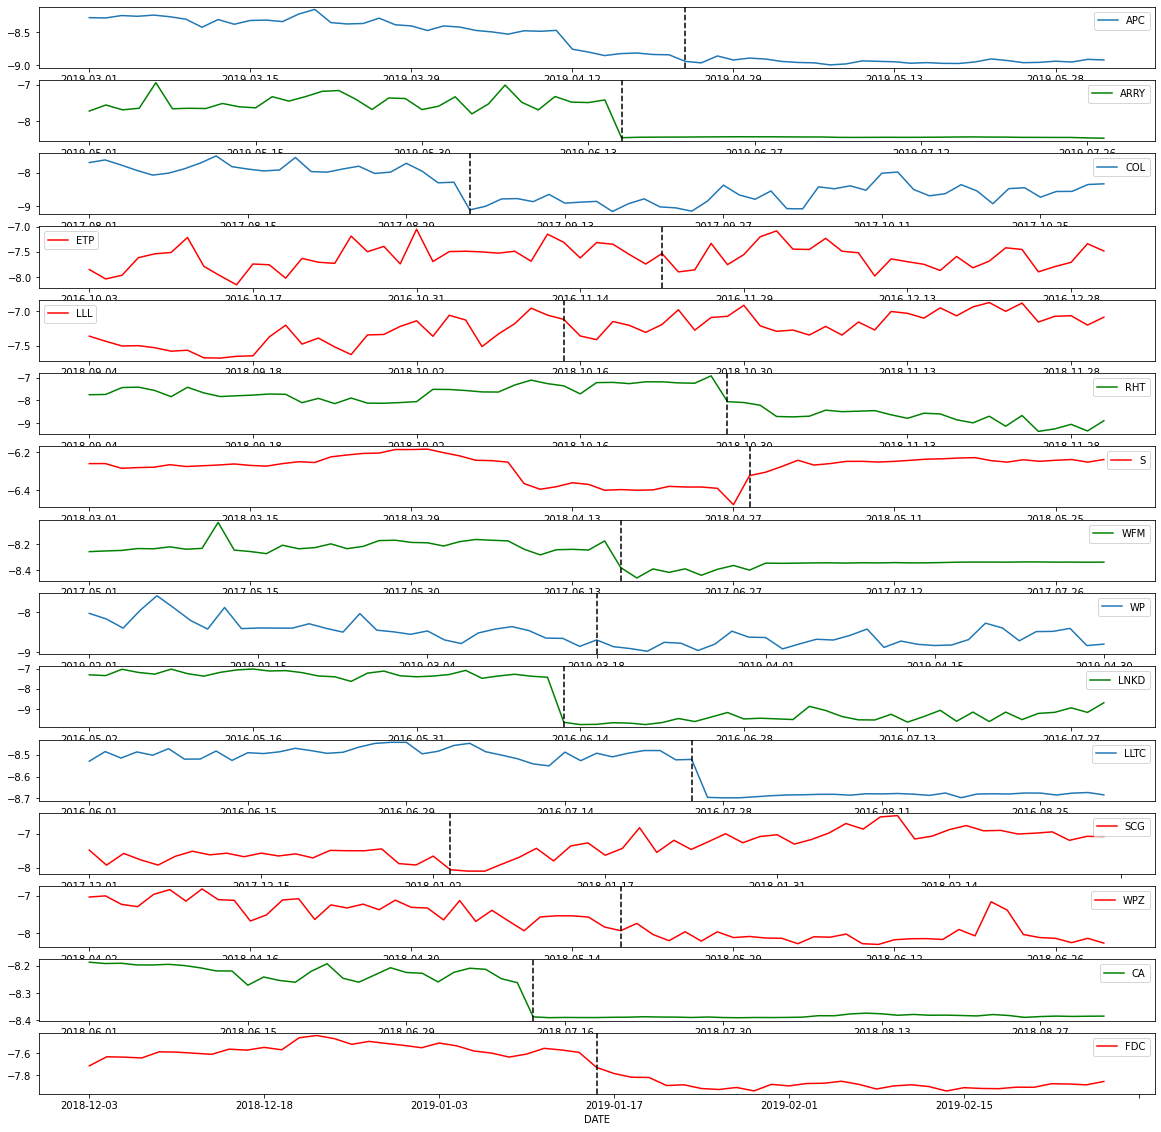

In [53]:
# Plot of pctSpread over time for TAR by company
f, a = plt.subplots(15,1,figsize=(20,20))
dfTARGroup.xs('APC').plot(y='pctSpread',ax=a[0],label='APC')
a[0].axvline(APC_DT, color='k', linestyle='--')

dfTARGroup.xs('ARRY').plot(y='pctSpread',ax=a[1],label='ARRY',color='g')
a[1].axvline(ARRY_DT, color='k', linestyle='--')

dfTARGroup.xs('COL').plot(y='pctSpread',ax=a[2],label='COL')
a[2].axvline(COL_DT, color='k', linestyle='--')

dfTARGroup.xs('ETP').plot(y='pctSpread',ax=a[3],label='ETP',color='r')
a[3].axvline(ETP_DT, color='k', linestyle='--')

dfTARGroup.xs('LLL').plot(y='pctSpread',ax=a[4],label='LLL',color='r')
a[4].axvline(LLL_DT, color='k', linestyle='--')

dfTARGroup.xs('RHT').plot(y='pctSpread',ax=a[5],label='RHT',color='g')
a[5].axvline(RHT_DT, color='k', linestyle='--')

dfTARGroup.xs('S').plot(y='pctSpread',ax=a[6],label='S',color='r')
a[6].axvline(S_DT, color='k', linestyle='--')

dfTARGroup.xs('WFM').plot(y='pctSpread',ax=a[7],label='WFM',color='g')
a[7].axvline(WFM_DT, color='k', linestyle='--')

dfTARGroup.xs('WP').plot(y='pctSpread',ax=a[8],label='WP')
a[8].axvline(WP_DT, color='k', linestyle='--')

dfTARGroup.xs('LNKD').plot(y='pctSpread',ax=a[9],label='LNKD',color='g')
a[9].axvline(LNKD_DT, color='k', linestyle='--')

dfTARGroup.xs('LLTC').plot(y='pctSpread',ax=a[10],label='LLTC')
a[10].axvline(LLTC_DT, color='k', linestyle='--')

dfTARGroup.xs('SCG').plot(y='pctSpread',ax=a[11],label='SCG',color='r')
a[11].axvline(SCG_DT, color='k', linestyle='--')

dfTARGroup.xs('WPZ').plot(y='pctSpread',ax=a[12],label='WPZ',color='r')
a[12].axvline(WPZ_DT, color='k', linestyle='--')

dfTARGroup.xs('CA').plot(y='pctSpread',ax=a[13],label='CA',color='g')
a[13].axvline(CA_DT, color='k', linestyle='--')

dfTARGroup.xs('FDC').plot(y='pctSpread',ax=a[14],label='FDC',color='r')
a[14].axvline(FDC_DT, color='k', linestyle='--')

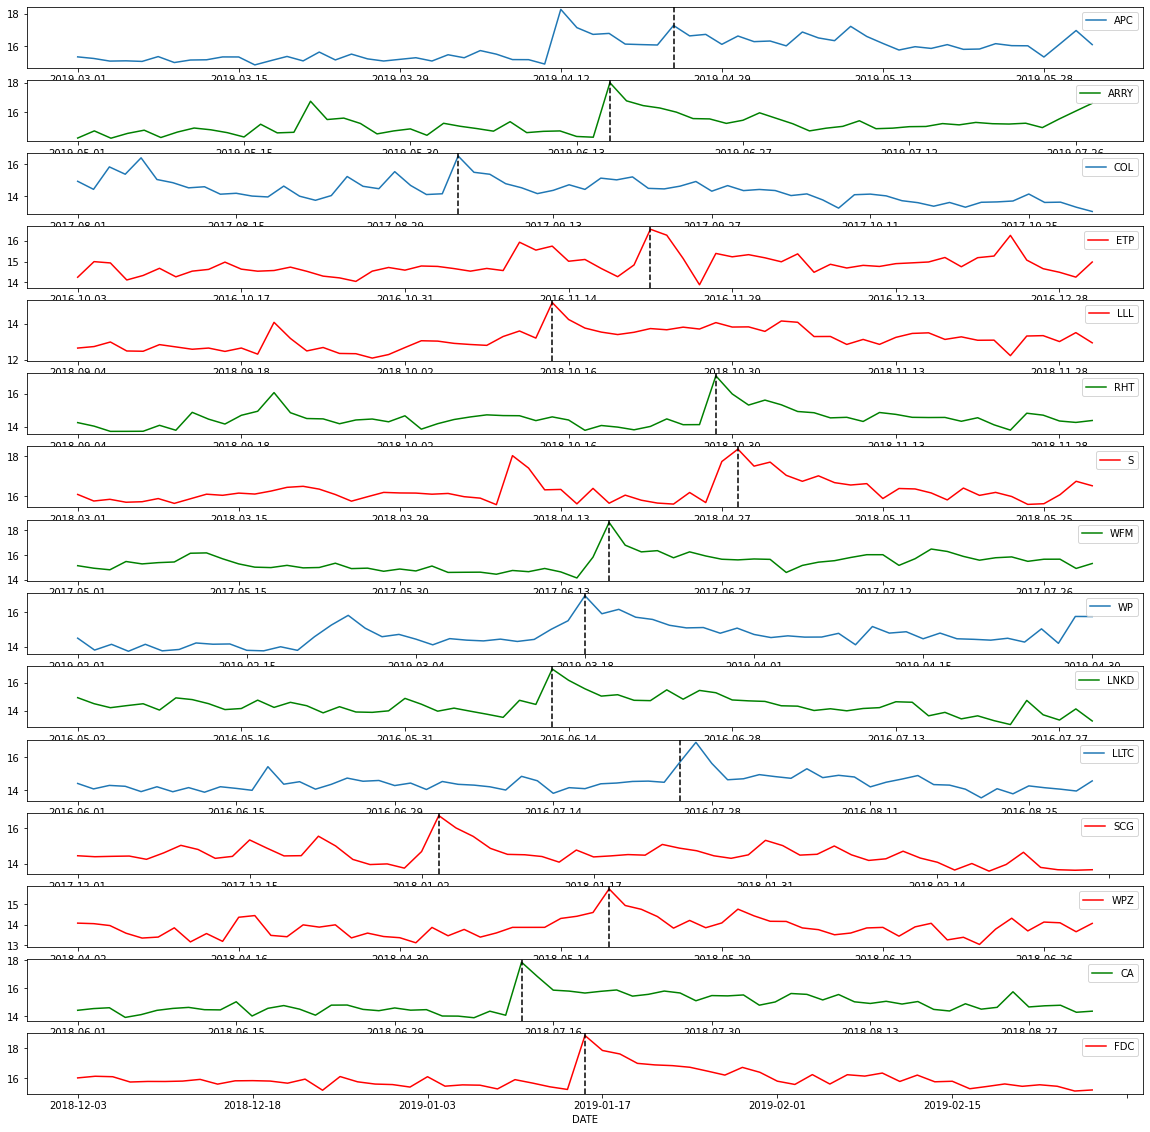

In [17]:
# Plot of logShareVolume over time for TAR by company
f, a = plt.subplots(15,1,figsize=(20,20))
dfTARGroup.xs('APC').plot(y='logShareVolume',ax=a[0],label='APC')
a[0].axvline(APC_DT, color='k', linestyle='--')

dfTARGroup.xs('ARRY').plot(y='logShareVolume',ax=a[1],label='ARRY',color='g')
a[1].axvline(ARRY_DT, color='k', linestyle='--')

dfTARGroup.xs('COL').plot(y='logShareVolume',ax=a[2],label='COL')
a[2].axvline(COL_DT, color='k', linestyle='--')

dfTARGroup.xs('ETP').plot(y='logShareVolume',ax=a[3],label='ETP',color='r')
a[3].axvline(ETP_DT, color='k', linestyle='--')

dfTARGroup.xs('LLL').plot(y='logShareVolume',ax=a[4],label='LLL',color='r')
a[4].axvline(LLL_DT, color='k', linestyle='--')

dfTARGroup.xs('RHT').plot(y='logShareVolume',ax=a[5],label='RHT',color='g')
a[5].axvline(RHT_DT, color='k', linestyle='--')

dfTARGroup.xs('S').plot(y='logShareVolume',ax=a[6],label='S',color='r')
a[6].axvline(S_DT, color='k', linestyle='--')

dfTARGroup.xs('WFM').plot(y='logShareVolume',ax=a[7],label='WFM',color='g')
a[7].axvline(WFM_DT, color='k', linestyle='--')

dfTARGroup.xs('WP').plot(y='logShareVolume',ax=a[8],label='WP')
a[8].axvline(WP_DT, color='k', linestyle='--')

dfTARGroup.xs('LNKD').plot(y='logShareVolume',ax=a[9],label='LNKD',color='g')
a[9].axvline(LNKD_DT, color='k', linestyle='--')

dfTARGroup.xs('LLTC').plot(y='logShareVolume',ax=a[10],label='LLTC')
a[10].axvline(LLTC_DT, color='k', linestyle='--')

dfTARGroup.xs('SCG').plot(y='logShareVolume',ax=a[11],label='SCG',color='r')
a[11].axvline(SCG_DT, color='k', linestyle='--')

dfTARGroup.xs('WPZ').plot(y='logShareVolume',ax=a[12],label='WPZ',color='r')
a[12].axvline(WPZ_DT, color='k', linestyle='--')

dfTARGroup.xs('CA').plot(y='logShareVolume',ax=a[13],label='CA',color='g')
a[13].axvline(CA_DT, color='k', linestyle='--')

dfTARGroup.xs('FDC').plot(y='logShareVolume',ax=a[14],label='FDC',color='r')
a[14].axvline(FDC_DT, color='k', linestyle='--')

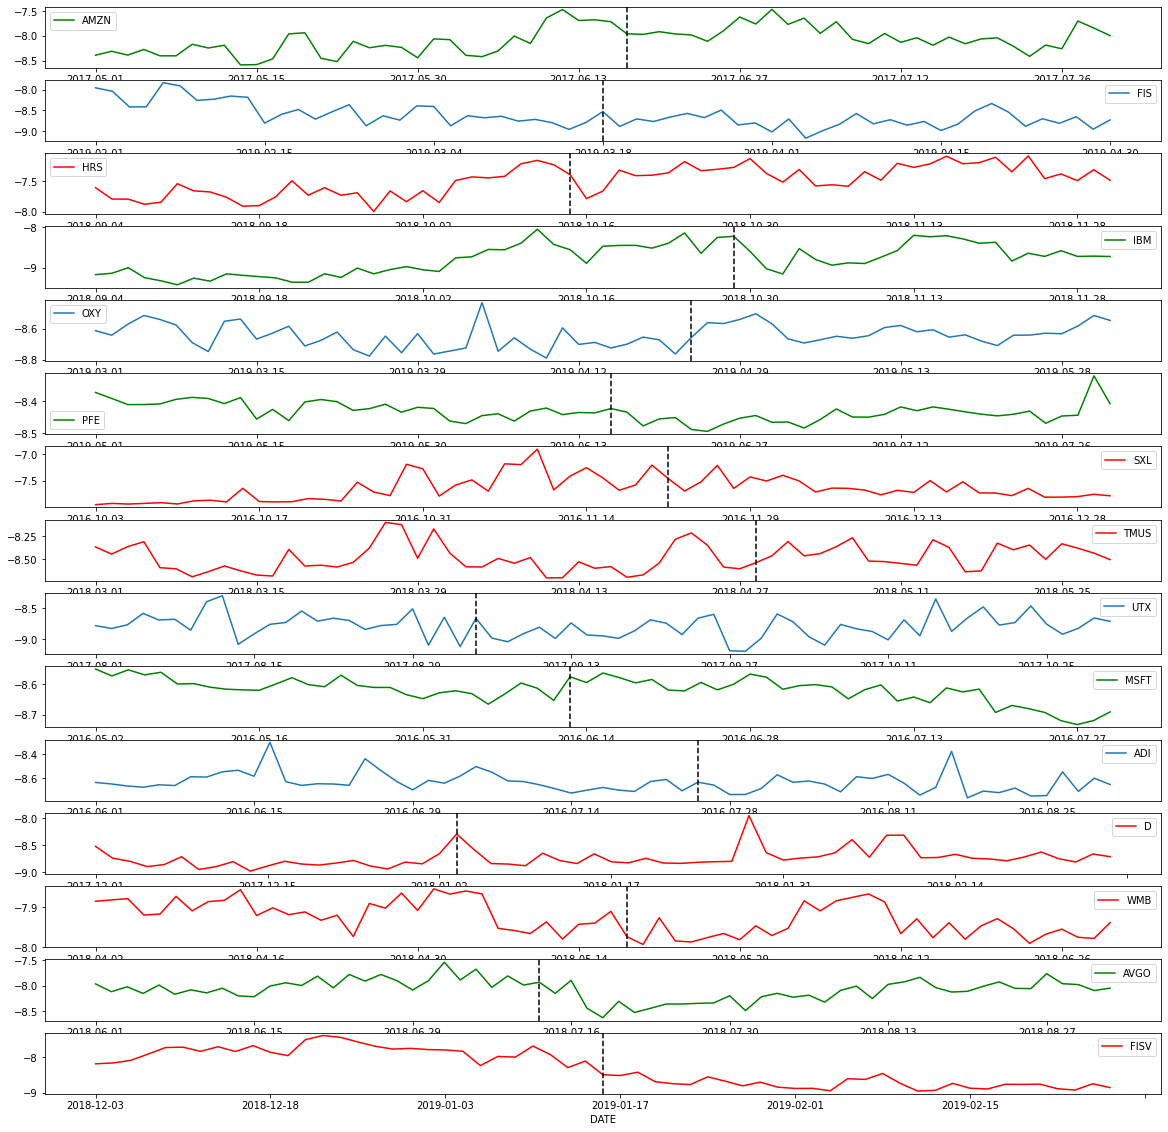

In [17]:
f, a = plt.subplots(15,1,figsize=(20,20))
dfACQGroup.xs('AMZN').plot(y='pctSpread',ax=a[0],label='AMZN',color='g')
a[0].axvline(AMZN_DT, color='k', linestyle='--')

dfACQGroup.xs('FIS').plot(y='pctSpread',ax=a[1],label='FIS')
a[1].axvline(FIS_DT, color='k', linestyle='--')

dfACQGroup.xs('HRS').plot(y='pctSpread',ax=a[2],label='HRS', color='r')
a[2].axvline(HRS_DT, color='k', linestyle='--')

dfACQGroup.xs('IBM').plot(y='pctSpread',ax=a[3],label='IBM',color='g')
a[3].axvline(IBM_DT, color='k', linestyle='--')

dfACQGroup.xs('OXY').plot(y='pctSpread',ax=a[4],label='OXY')
a[4].axvline(OXY_DT, color='k', linestyle='--')

dfACQGroup.xs('PFE').plot(y='pctSpread',ax=a[5],label='PFE',color='g')
a[5].axvline(PFE_DT, color='k', linestyle='--')

dfACQGroup.xs('SXL').plot(y='pctSpread',ax=a[6],label='SXL',color='r')
a[6].axvline(SXL_DT, color='k', linestyle='--')

dfACQGroup.xs('TMUS').plot(y='pctSpread',ax=a[7],label='TMUS',color='r')
a[7].axvline(TMUS_DT, color='k', linestyle='--')

dfACQGroup.xs('UTX').plot(y='pctSpread',ax=a[8],label='UTX')
a[8].axvline(UTX_DT, color='k', linestyle='--')

dfACQGroup.xs('MSFT').plot(y='pctSpread',ax=a[9],label='MSFT',color='g')
a[9].axvline(MSFT_DT, color='k', linestyle='--')

dfACQGroup.xs('ADI').plot(y='pctSpread',ax=a[10],label='ADI')
a[10].axvline(ADI_DT, color='k', linestyle='--')

dfACQGroup.xs('D').plot(y='pctSpread',ax=a[11],label='D',color='r')
a[11].axvline(D_DT, color='k', linestyle='--')

dfACQGroup.xs('WMB').plot(y='pctSpread',ax=a[12],label='WMB',color='r')
a[12].axvline(WMB_DT, color='k', linestyle='--')

dfACQGroup.xs('AVGO').plot(y='pctSpread',ax=a[13],label='AVGO',color='g')
a[13].axvline(AVGO_DT, color='k', linestyle='--')

dfACQGroup.xs('FISV').plot(y='pctSpread',ax=a[14],label='FISV',color='r')
a[14].axvline(FISV_DT, color='k', linestyle='--')

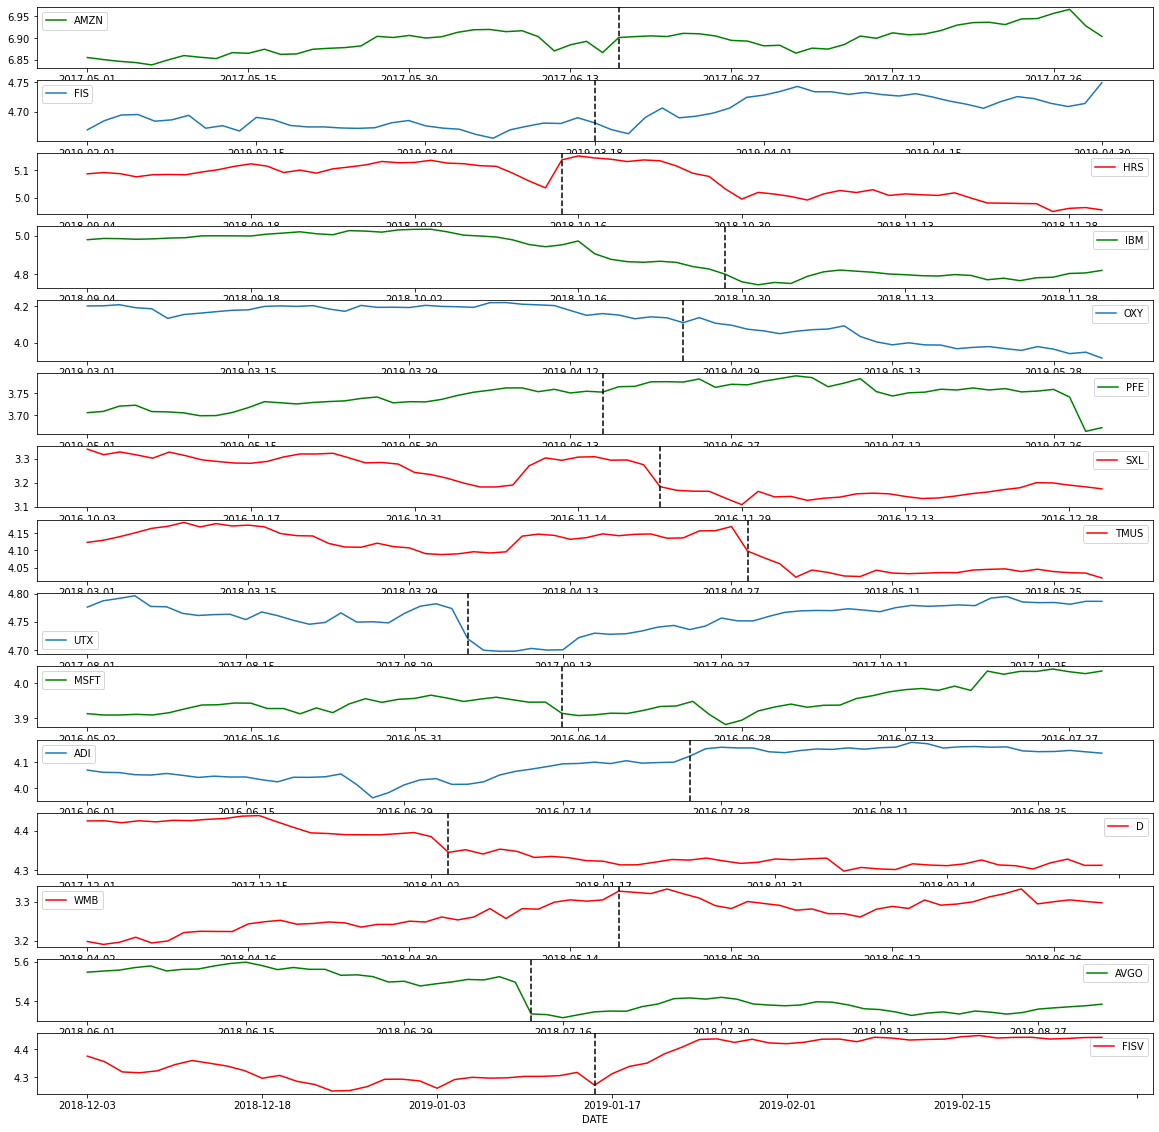

In [18]:
f, a = plt.subplots(15,1,figsize=(20,20))
dfACQGroup.xs('AMZN').plot(y='logPrice',ax=a[0],label='AMZN',color='g')
a[0].axvline(AMZN_DT, color='k', linestyle='--')

dfACQGroup.xs('FIS').plot(y='logPrice',ax=a[1],label='FIS')
a[1].axvline(FIS_DT, color='k', linestyle='--')

dfACQGroup.xs('HRS').plot(y='logPrice',ax=a[2],label='HRS', color='r')
a[2].axvline(HRS_DT, color='k', linestyle='--')

dfACQGroup.xs('IBM').plot(y='logPrice',ax=a[3],label='IBM',color='g')
a[3].axvline(IBM_DT, color='k', linestyle='--')

dfACQGroup.xs('OXY').plot(y='logPrice',ax=a[4],label='OXY')
a[4].axvline(OXY_DT, color='k', linestyle='--')

dfACQGroup.xs('PFE').plot(y='logPrice',ax=a[5],label='PFE',color='g')
a[5].axvline(PFE_DT, color='k', linestyle='--')

dfACQGroup.xs('SXL').plot(y='logPrice',ax=a[6],label='SXL',color='r')
a[6].axvline(SXL_DT, color='k', linestyle='--')

dfACQGroup.xs('TMUS').plot(y='logPrice',ax=a[7],label='TMUS',color='r')
a[7].axvline(TMUS_DT, color='k', linestyle='--')

dfACQGroup.xs('UTX').plot(y='logPrice',ax=a[8],label='UTX')
a[8].axvline(UTX_DT, color='k', linestyle='--')

dfACQGroup.xs('MSFT').plot(y='logPrice',ax=a[9],label='MSFT',color='g')
a[9].axvline(MSFT_DT, color='k', linestyle='--')

dfACQGroup.xs('ADI').plot(y='logPrice',ax=a[10],label='ADI')
a[10].axvline(ADI_DT, color='k', linestyle='--')

dfACQGroup.xs('D').plot(y='logPrice',ax=a[11],label='D',color='r')
a[11].axvline(D_DT, color='k', linestyle='--')

dfACQGroup.xs('WMB').plot(y='logPrice',ax=a[12],label='WMB',color='r')
a[12].axvline(WMB_DT, color='k', linestyle='--')

dfACQGroup.xs('AVGO').plot(y='logPrice',ax=a[13],label='AVGO',color='g')
a[13].axvline(AVGO_DT, color='k', linestyle='--')

dfACQGroup.xs('FISV').plot(y='logPrice',ax=a[14],label='FISV',color='r')
a[14].axvline(FISV_DT, color='k', linestyle='--')

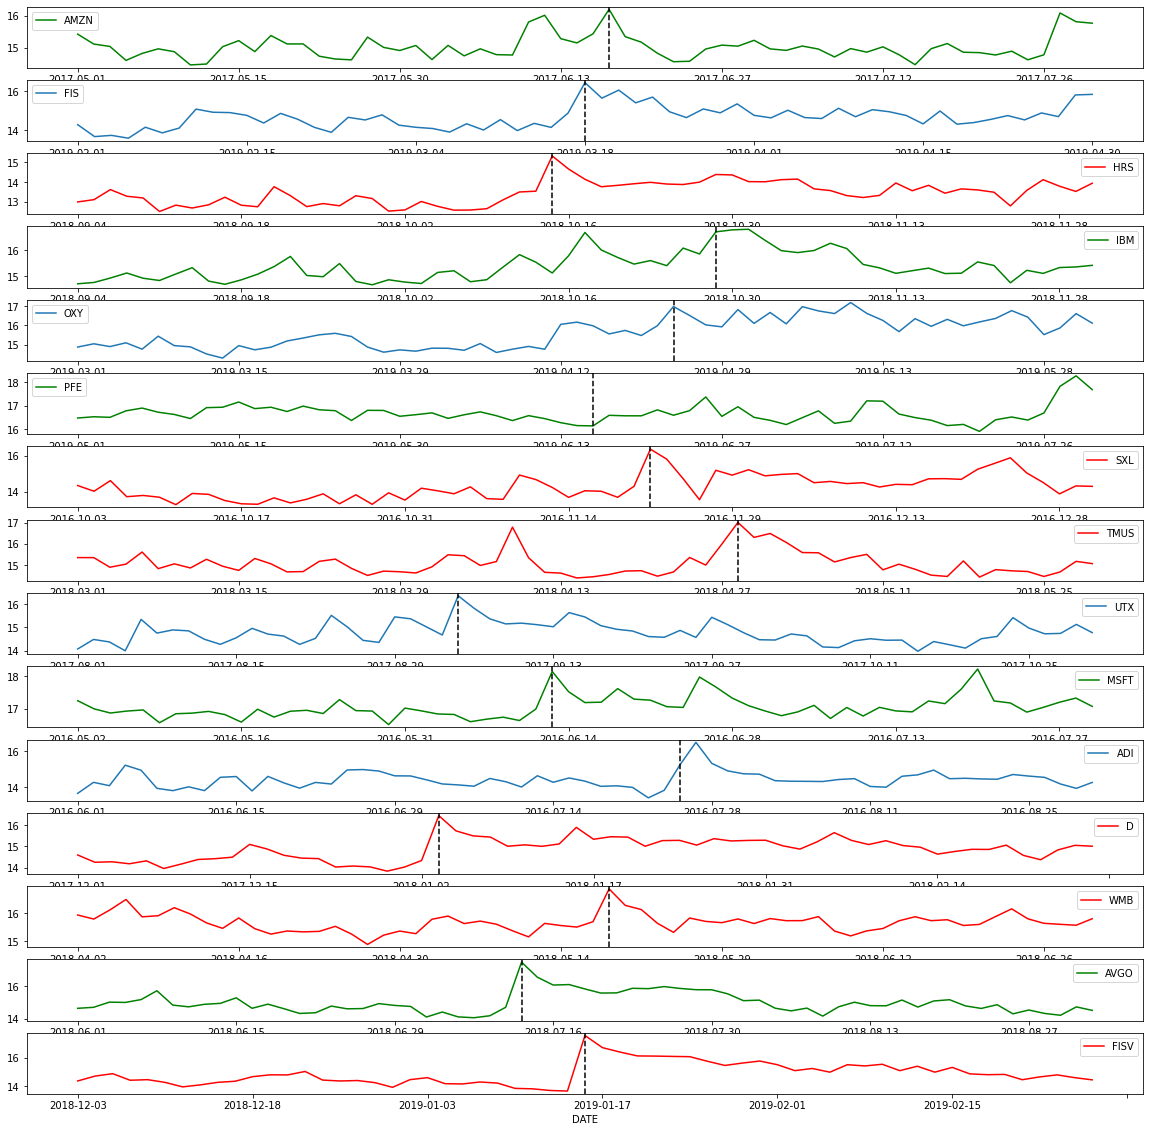

In [26]:
f, a = plt.subplots(15,1,figsize=(20,20))
dfACQGroup.xs('AMZN').plot(y='logShareVolume',ax=a[0],label='AMZN',color='g')
a[0].axvline(AMZN_DT, color='k', linestyle='--')

dfACQGroup.xs('FIS').plot(y='logShareVolume',ax=a[1],label='FIS')
a[1].axvline(FIS_DT, color='k', linestyle='--')

dfACQGroup.xs('HRS').plot(y='logShareVolume',ax=a[2],label='HRS', color='r')
a[2].axvline(HRS_DT, color='k', linestyle='--')

dfACQGroup.xs('IBM').plot(y='logShareVolume',ax=a[3],label='IBM',color='g')
a[3].axvline(IBM_DT, color='k', linestyle='--')

dfACQGroup.xs('OXY').plot(y='logShareVolume',ax=a[4],label='OXY')
a[4].axvline(OXY_DT, color='k', linestyle='--')

dfACQGroup.xs('PFE').plot(y='logShareVolume',ax=a[5],label='PFE',color='g')
a[5].axvline(PFE_DT, color='k', linestyle='--')

dfACQGroup.xs('SXL').plot(y='logShareVolume',ax=a[6],label='SXL',color='r')
a[6].axvline(SXL_DT, color='k', linestyle='--')

dfACQGroup.xs('TMUS').plot(y='logShareVolume',ax=a[7],label='TMUS',color='r')
a[7].axvline(TMUS_DT, color='k', linestyle='--')

dfACQGroup.xs('UTX').plot(y='logShareVolume',ax=a[8],label='UTX')
a[8].axvline(UTX_DT, color='k', linestyle='--')

dfACQGroup.xs('MSFT').plot(y='logShareVolume',ax=a[9],label='MSFT',color='g')
a[9].axvline(MSFT_DT, color='k', linestyle='--')

dfACQGroup.xs('ADI').plot(y='logShareVolume',ax=a[10],label='ADI')
a[10].axvline(ADI_DT, color='k', linestyle='--')

dfACQGroup.xs('D').plot(y='logShareVolume',ax=a[11],label='D',color='r')
a[11].axvline(D_DT, color='k', linestyle='--')

dfACQGroup.xs('WMB').plot(y='logShareVolume',ax=a[12],label='WMB',color='r')
a[12].axvline(WMB_DT, color='k', linestyle='--')

dfACQGroup.xs('AVGO').plot(y='logShareVolume',ax=a[13],label='AVGO',color='g')
a[13].axvline(AVGO_DT, color='k', linestyle='--')

dfACQGroup.xs('FISV').plot(y='logShareVolume',ax=a[14],label='FISV',color='r')
a[14].axvline(FISV_DT, color='k', linestyle='--')

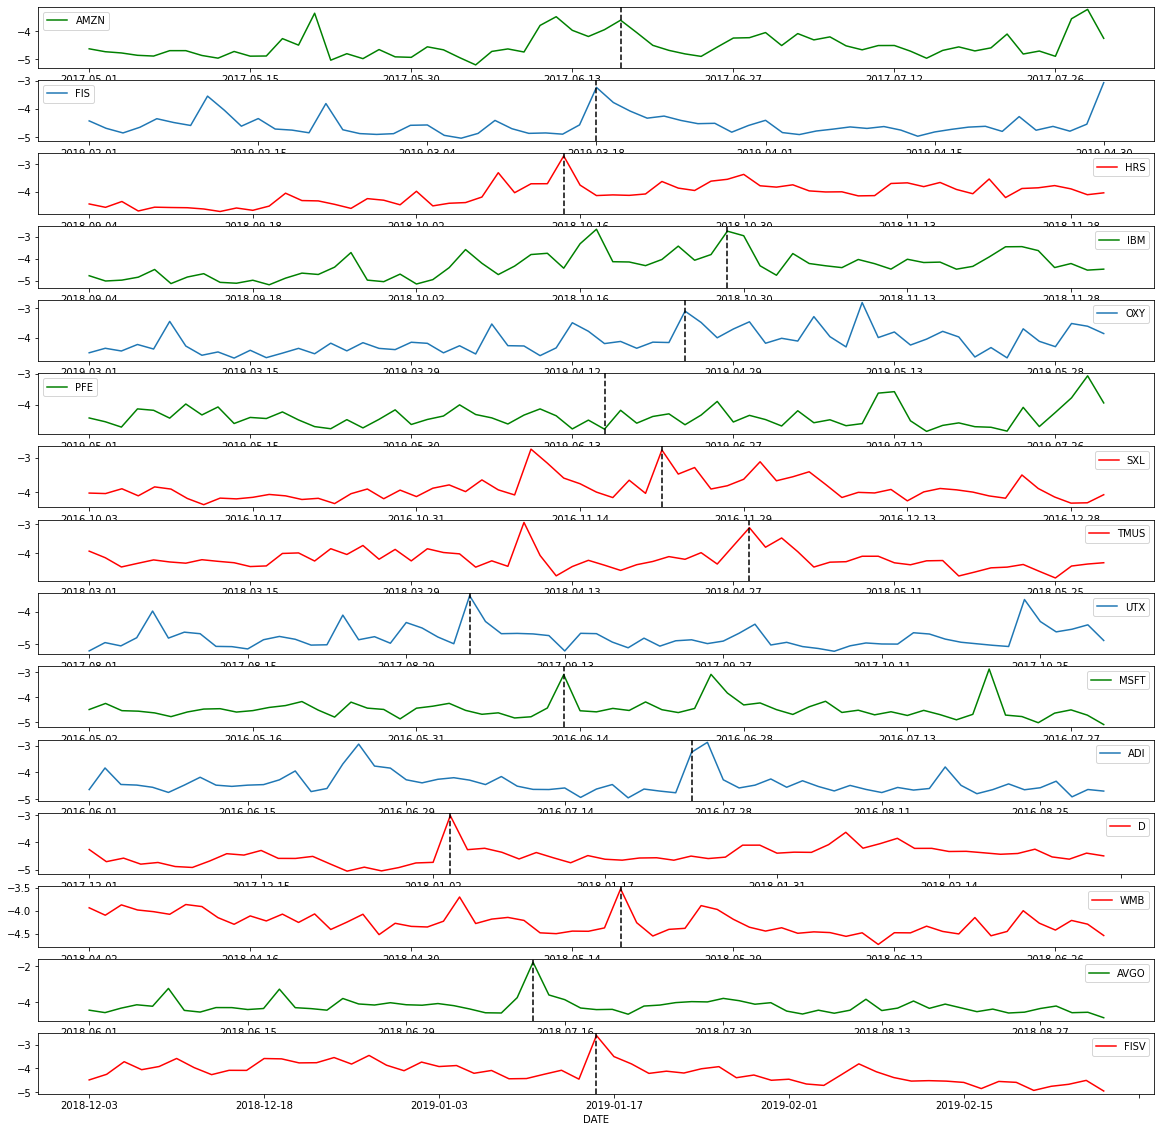

In [27]:
f, a = plt.subplots(15,1,figsize=(20,20))
dfACQGroup.xs('AMZN').plot(y='logDayVolatility',ax=a[0],label='AMZN',color='g')
a[0].axvline(AMZN_DT, color='k', linestyle='--')

dfACQGroup.xs('FIS').plot(y='logDayVolatility',ax=a[1],label='FIS')
a[1].axvline(FIS_DT, color='k', linestyle='--')

dfACQGroup.xs('HRS').plot(y='logDayVolatility',ax=a[2],label='HRS', color='r')
a[2].axvline(HRS_DT, color='k', linestyle='--')

dfACQGroup.xs('IBM').plot(y='logDayVolatility',ax=a[3],label='IBM',color='g')
a[3].axvline(IBM_DT, color='k', linestyle='--')

dfACQGroup.xs('OXY').plot(y='logDayVolatility',ax=a[4],label='OXY')
a[4].axvline(OXY_DT, color='k', linestyle='--')

dfACQGroup.xs('PFE').plot(y='logDayVolatility',ax=a[5],label='PFE',color='g')
a[5].axvline(PFE_DT, color='k', linestyle='--')

dfACQGroup.xs('SXL').plot(y='logDayVolatility',ax=a[6],label='SXL',color='r')
a[6].axvline(SXL_DT, color='k', linestyle='--')

dfACQGroup.xs('TMUS').plot(y='logDayVolatility',ax=a[7],label='TMUS',color='r')
a[7].axvline(TMUS_DT, color='k', linestyle='--')

dfACQGroup.xs('UTX').plot(y='logDayVolatility',ax=a[8],label='UTX')
a[8].axvline(UTX_DT, color='k', linestyle='--')

dfACQGroup.xs('MSFT').plot(y='logDayVolatility',ax=a[9],label='MSFT',color='g')
a[9].axvline(MSFT_DT, color='k', linestyle='--')

dfACQGroup.xs('ADI').plot(y='logDayVolatility',ax=a[10],label='ADI')
a[10].axvline(ADI_DT, color='k', linestyle='--')

dfACQGroup.xs('D').plot(y='logDayVolatility',ax=a[11],label='D',color='r')
a[11].axvline(D_DT, color='k', linestyle='--')

dfACQGroup.xs('WMB').plot(y='logDayVolatility',ax=a[12],label='WMB',color='r')
a[12].axvline(WMB_DT, color='k', linestyle='--')

dfACQGroup.xs('AVGO').plot(y='logDayVolatility',ax=a[13],label='AVGO',color='g')
a[13].axvline(AVGO_DT, color='k', linestyle='--')

dfACQGroup.xs('FISV').plot(y='logDayVolatility',ax=a[14],label='FISV',color='r')
a[14].axvline(FISV_DT, color='k', linestyle='--')

In [21]:
# TAR deals
regtest = smf.ols('logShareVolume ~ Announced',data=dfTAR).fit(cov_type='HAC',cov_kwds={'maxlags':2})
print(regtest.summary())

                            OLS Regression Results                            
Dep. Variable:         logShareVolume   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     9.799
Date:                Thu, 15 Apr 2021   Prob (F-statistic):            0.00180
Time:                        02:01:51   Log-Likelihood:                -1338.0
No. Observations:                 945   AIC:                             2680.
Df Residuals:                     943   BIC:                             2690.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.6659      0.068    215.457      0.0

In [22]:
# TAR deals
regtest = smf.ols('logDayVolatility ~ Announced',data=dfTAR).fit(cov_type='HAC',cov_kwds={'maxlags':2})
print(regtest.summary())

                            OLS Regression Results                            
Dep. Variable:       logDayVolatility   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     72.94
Date:                Thu, 15 Apr 2021   Prob (F-statistic):           5.30e-17
Time:                        02:02:21   Log-Likelihood:                -1062.0
No. Observations:                 945   AIC:                             2128.
Df Residuals:                     943   BIC:                             2138.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.0064      0.032   -126.237      0.0

In [23]:
# ACQ deals
regtest = smf.ols('logShareVolume ~ Announced',data=dfACQ).fit(cov_type='HAC',cov_kwds={'maxlags':2})
print(regtest.summary())

                            OLS Regression Results                            
Dep. Variable:         logShareVolume   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     20.95
Date:                Thu, 15 Apr 2021   Prob (F-statistic):           5.33e-06
Time:                        02:02:45   Log-Likelihood:                -1343.7
No. Observations:                 947   AIC:                             2691.
Df Residuals:                     945   BIC:                             2701.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.8847      0.077    193.471      0.0

In [24]:
# ACQ deals
regtest = smf.ols('logDayVolatility ~ Announced',data=dfACQ).fit(cov_type='HAC',cov_kwds={'maxlags':2})
print(regtest.summary())

                            OLS Regression Results                            
Dep. Variable:       logDayVolatility   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.223
Date:                Thu, 15 Apr 2021   Prob (F-statistic):             0.0729
Time:                        02:03:08   Log-Likelihood:                -582.59
No. Observations:                 947   AIC:                             1169.
Df Residuals:                     945   BIC:                             1179.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.3578      0.027   -162.416      0.0